# Predicting Implicit Patterns and Optimizing Market Entry and Exit Decisions in Stock Prices using integrated Bayesian CNN-LSTM with Deep Q-Learning as a Meta-Labelle

**We are doing the following in this project**

- Train a Bayesian CNN-LSTM hybrid to predict the stock returns
- In the process estimate the uncertianty of the Bayesian CNN-LSTM prediction
- Use the Bayesian CNN--LSTM prediction and the uncertainty estimations as states to train Deep Q-learning agent (DQA).
- The purpose of training the DQA is to determine the size of bet based on Bayesian CNN-LSTM prediction and the uncertainty of the prediction of the Bayesian CNN-LSTM prediction

In [1]:
import datetime
import math

import numpy as np
import pandas_datareader.data as web
import seaborn as sns
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox,probplot,shapiro
# from sklearn_fracdiff import FracDiff
from sklearn.model_selection import train_test_split
from pyts.image import GramianAngularField
from keras.models import Sequential
from keras.layers import Conv1D,Bidirectional, MaxPooling1D, Flatten, Dense,Reshape,LSTM,Dropout,TimeDistributed
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from keras.optimizers import Adam
from keras import backend as keras_b
import tensorflow as tf
from keras.models import load_model
from sklearn.model_selection import ParameterGrid
import random
from collections import deque
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (16, 9)

# **1. DATA COLLECTION FOR TRAINING & TESTING**

We will collect APPLE Stocks from 2005-01-01 to 2021-12-21

In [2]:
# Defined start and end dates for the data
start_date = '2010-01-01'
end_date = '2022-12-31'

# Fetch the data using the Yahoo Finance API
apple_data = yf.download('AAPL', start=start_date, end=end_date)
# Display the first few rows of the data
print(apple_data.head())
apple_data.to_csv("apple_stock_prices.csv")

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.470740  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.481929  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.378828  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.367032  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.409362  447610800


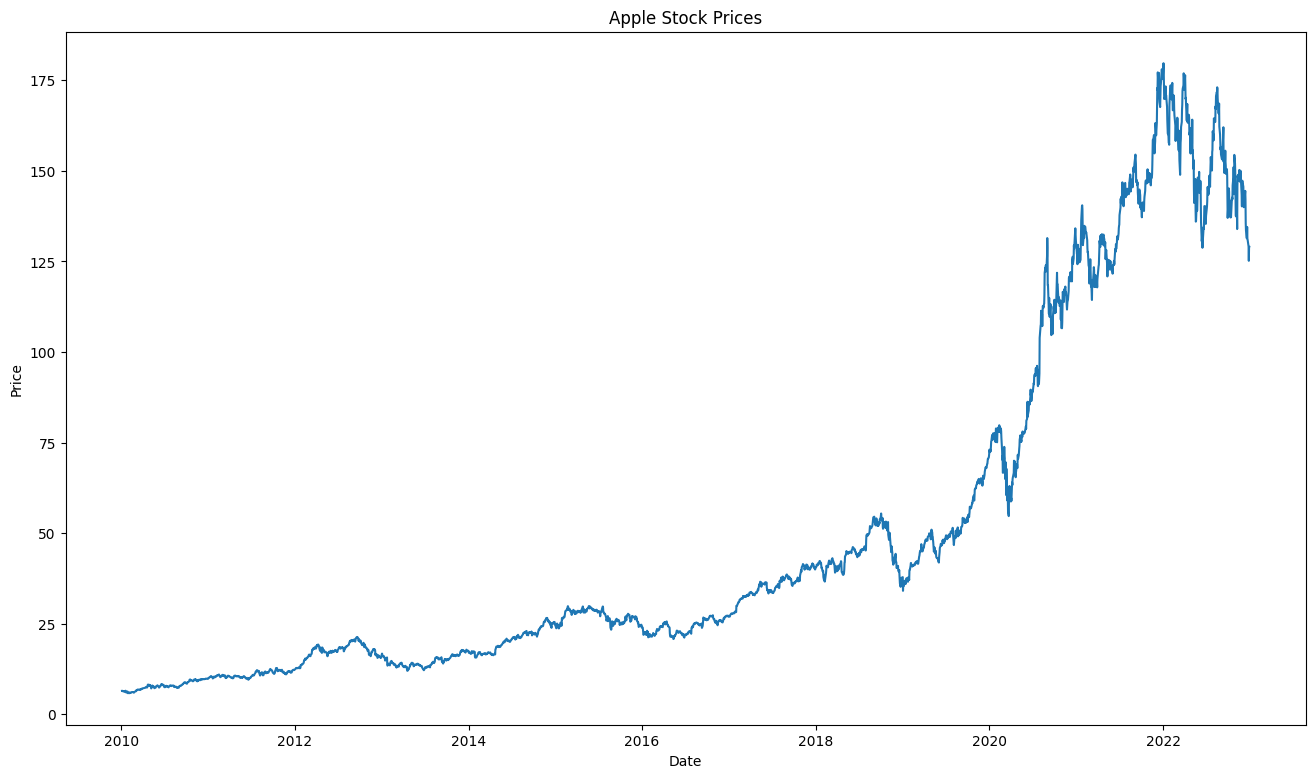

In [2]:
# Load the data from the CSV file
data = pd.read_csv("apple_stock_prices.csv")

# Convert the 'Date' column to datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Create the line plot
plt.plot(data["Date"], data["Adj Close"])
plt.title("Apple Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

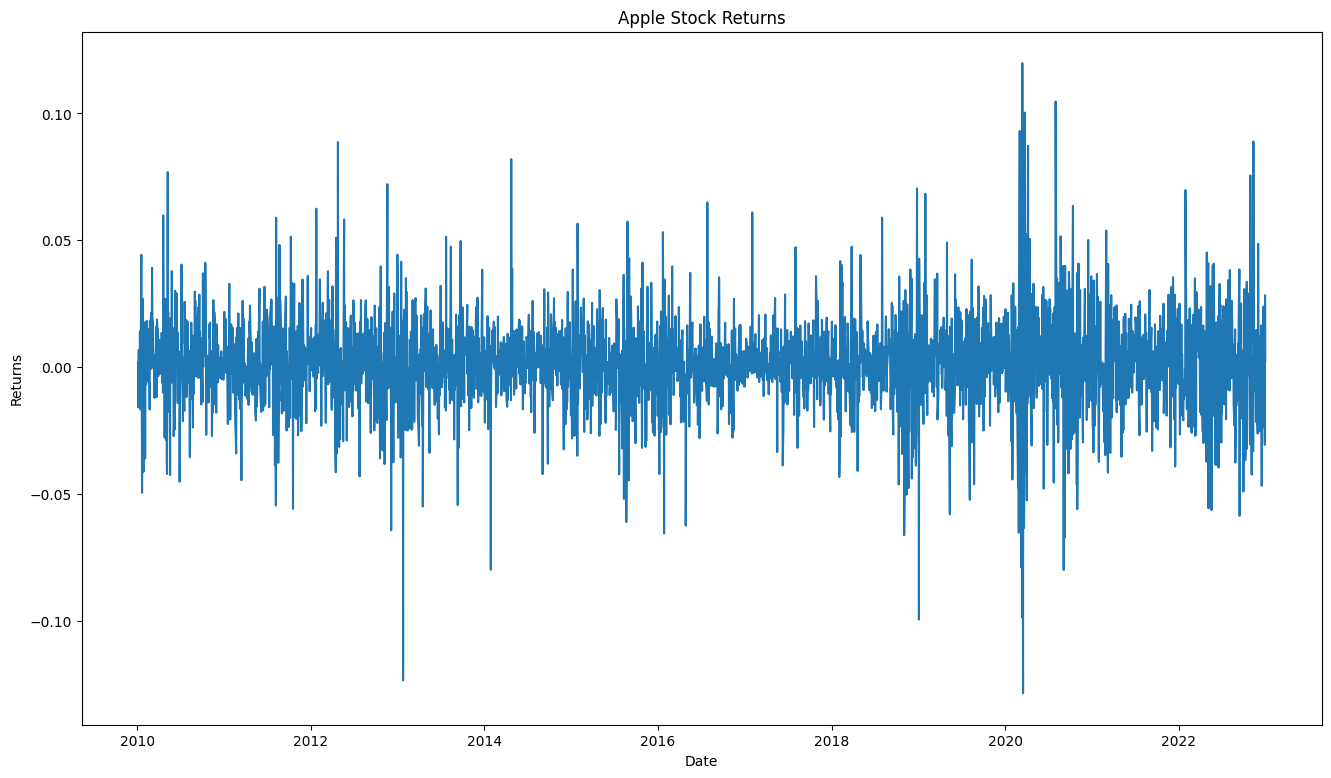

In [3]:
# Calculate the returns
data['Returns'] = data['Adj Close'].pct_change()


# Drop rows with missing values (NaNs) resulting from the shifting
data.dropna(inplace=True)
# Create the line plot
plt.plot(data["Date"], data["Returns"])
plt.title("Apple Stock Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

In [5]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Returns
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481929,601904800,0.001729
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378828,552160000,-0.015906
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367032,477131200,-0.001849
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409362,447610800,0.006648
5,2010-01-11,7.600000,7.607143,7.444643,7.503929,6.352821,462229600,-0.008822


# **2 Reprocess the return**

- For each window of 100 consecutive data points,`X[i]`, the percentage change $\delta x_i$ is calculated relative to the first data point in the window. This is represented by:

  $$\delta x_i = \frac{x_{100+i} - x_i}{x_i}$$

  where $x_{100+i}$ is the value at the end of the window (i.e., the 100th data point), and $x_i$ is the value at the start of the window (i.e., the 1st data point).

- For the corresponding target value,  `Y[i]`, the percentage change $\delta y_i$ is calculated as the difference between the value at the next time step (i.e., $x_{101+i}$) and the value at the start of the window (i.e., $x_i$), divided by the value at the start of the window. This is represented by:

  $$\delta y_i = \frac{x_{101+i} - x_i}{x_i}$$

Consequently, `X[i]` represents the percentage change within the window, and `Y[i]` represents the percentage change at the next time step after the window.

In [4]:
X = []
Y = []
window_size=100
for i in range(1 , len(data) - window_size -1 , 1):
    first = data.iloc[i,5]
    # print(first)
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((data.iloc[i + j, 5] - first) / first)
    temp2.append((data.iloc[i + window_size, 5] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))
# Split the data into training, validation, and testing sets
X_train_val, X_test_, y_train_val, y_test_ = train_test_split(
    X, Y, test_size=0.2, shuffle=True
)

# # Further split the training set into training and validation sets
X_train_, X_val_, y_train_, y_val_ = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,
    shuffle=True
)

X_train = np.array(X_train_)
X_test = np.array(X_test_)
X_val = np.array(X_val_)
y_train = np.array(y_train_)
y_val = np.array(y_val_)
y_test = np.array(y_test_)
# # Reshape the input data for CNN (channels last)
X_train = X_train.reshape(X_train.shape[0],1,100,1)
X_val = X_val.reshape(X_val.shape[0],1,100,1)
X_test = X_test.reshape(X_test.shape[0],1,100,1)

print(len(X_train))
print(len(X_val))
print(len(X_test))

2028
507
634


In [7]:
# y_test

In [8]:
len(X)

3169


# **3. Training the Bayesian CNN-LSTM**

Combining Monte Carlo Dropout (MC Dropout) with a Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) network involves extending the MC Dropout methodology to both the CNN and LSTM components. Below are the steps to incorporate MC Dropout into a hybrid Bayesian CNN-LSTM model:

1. **Modify the CNN-LSTM Architecture:**
   - Introduce dropout layers after convolutional layers in the CNN part and after the LSTM layers in the LSTM part of your architecture.

In [9]:
# For creating model and training
model_bay_cnn_lstm = Sequential()

# Creating the Neural Network model here...
# CNN layers
model_bay_cnn_lstm.add(
    TimeDistributed(
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 1,100, 1)
              )
    )
)
model_bay_cnn_lstm.add(
    TimeDistributed(
        Dropout(0.25)
    )
)
model_bay_cnn_lstm.add(
    TimeDistributed(
        MaxPooling1D(2)
    )
)
model_bay_cnn_lstm.add(
    TimeDistributed(
        Conv1D(128, kernel_size=3, activation='relu')
    )
)
model_bay_cnn_lstm.add(
    TimeDistributed(
        MaxPooling1D(2)
    )
)
model_bay_cnn_lstm.add(
    TimeDistributed(
        Conv1D(64, kernel_size=3, activation='relu')
    )
)
model_bay_cnn_lstm.add(TimeDistributed(MaxPooling1D(2)))
model_bay_cnn_lstm.add(TimeDistributed(Flatten()))

# LSTM layers
model_bay_cnn_lstm.add(Bidirectional(LSTM(100, return_sequences=True)))
model_bay_cnn_lstm.add(Bidirectional(LSTM(100, return_sequences=False)))
model_bay_cnn_lstm.add(Dropout(0.5))

#Final layers
model_bay_cnn_lstm.add(Dense(1, activation='linear'))
model_bay_cnn_lstm.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

2. **Enable Dropout During Inference:**
   
  To perform MC Dropout during inference, we need to manually enable dropout at test time. This involves setting the training parameter of the model to True during inference. This step is crucial for obtaining multiple predictions with varying dropout masks..

In [13]:
def enable_dropout(model_bay_cnn_lstm):
    for layer in model_bay_cnn_lstm.layers:
        if isinstance(layer, (Dropout, LSTM, TimeDistributed)):
            layer.training = True


3. **Training:**
   We train the model as we would with a standard CNN, but with the dropout layers included. The dropout layers are automatically active during training.

In [11]:
# # Train the model

history = model_bay_cnn_lstm.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
    verbose=0
)


4. **Perform Multiple Predictions:**
   - When making predictions,we  enable dropout during inference, and make multiple predictions to capture uncertainty.

In [12]:
num_predictions = 100
predictions = []

for _ in range(num_predictions):
    enable_dropout(model_bay_cnn_lstm)
    pred = model_bay_cnn_lstm.predict(X_test,verbose=0)  # x_test is your test data
    predictions.append(pred)

predictions = np.array(predictions)


5. **Aggregating Predictions:**
   
We aggregate the predictions to obtain a measure of uncertainty. We shall use the mean or variance of the predictions as aggregation method. The mean prediction provides an estimate of the point prediction, while the variance can be considered a measure of uncertainty..

In [13]:
mean_prediction = np.mean(predictions, axis=0)
uncertainty = np.var(predictions, axis=0)


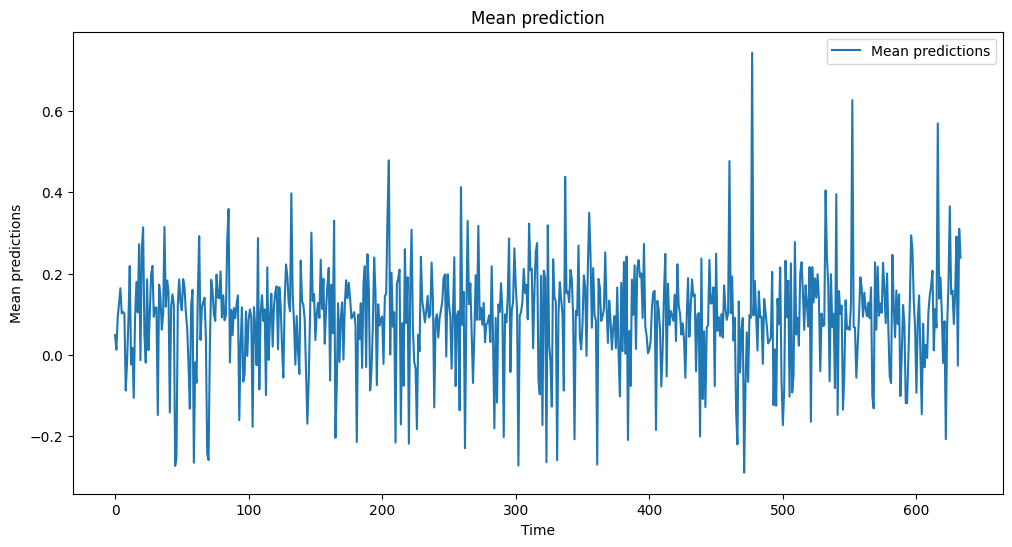

In [14]:
# uncertainty
plt.figure(figsize=(12, 6))
plt.plot(mean_prediction, label='Mean predictions')
plt.xlabel('Time')
plt.ylabel('Mean predictions')
plt.title('Mean prediction')
plt.legend()
plt.show()

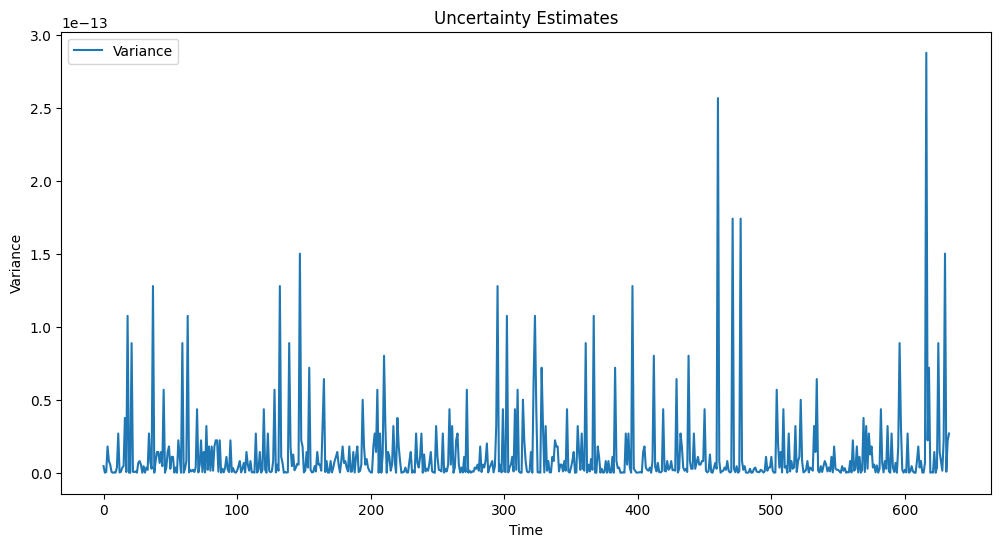

In [15]:
# uncertainty
plt.figure(figsize=(12, 6))
plt.plot(uncertainty, label='Variance')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title('Uncertainty Estimates')
plt.legend()
plt.show()

**Save the Bayesian CNN-LSTM model**

In [16]:
# Save the model architecture as JSON
model_bay_cnn_lstm_json = model_bay_cnn_lstm.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_bay_cnn_lstm_json)

# Save the model weights
model_bay_cnn_lstm.save_weights("trained_bayesian_CNN_LSTM_weights.h5")

# Optionally, saving the entire model (including architecture and weights) in a single .h5 file
model_bay_cnn_lstm.save("complete_bayesian_cnn_lstm.h5")

# model_bay_cnn_lstm.save_weights('trained_bayesian_CNN_LSTM_weights.h5')

In [77]:
# Load the saved model
loaded_bay_cnn_lstm_model = load_model('complete_bayesian_cnn_lstm.h5')

In [78]:
# # Evaluate the model on the validation and test sets
val_loss = loaded_bay_cnn_lstm_model.evaluate(X_val, y_val)
test_loss = loaded_bay_cnn_lstm_model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Test loss:", test_loss)

# Make predictions
y_pred = loaded_bay_cnn_lstm_model.predict(X_test)

20/20 [==============================] - 0s 17ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0533
Validation loss: [0.005087577272206545, 0.005087577272206545, 0.054742660373449326]
Test loss: [0.0049483939073979855, 0.0049483939073979855, 0.05327653884887695]
20/20 [==============================] - 3s 13ms/step


In [18]:
X_test.shape

(634, 1, 100, 1)

In [19]:
y_pred.shape

(634, 1)

In [176]:
y_test_list=[]
for i in y_test:
    y_test_list.append(i)

In [177]:
data2=pd.DataFrame(y_pred,columns=["pred"])
data2["real"]=y_test_list

In [22]:
# y_test

In [23]:
# data2.head(10)

20/20 [==============================] - 0s 12ms/step


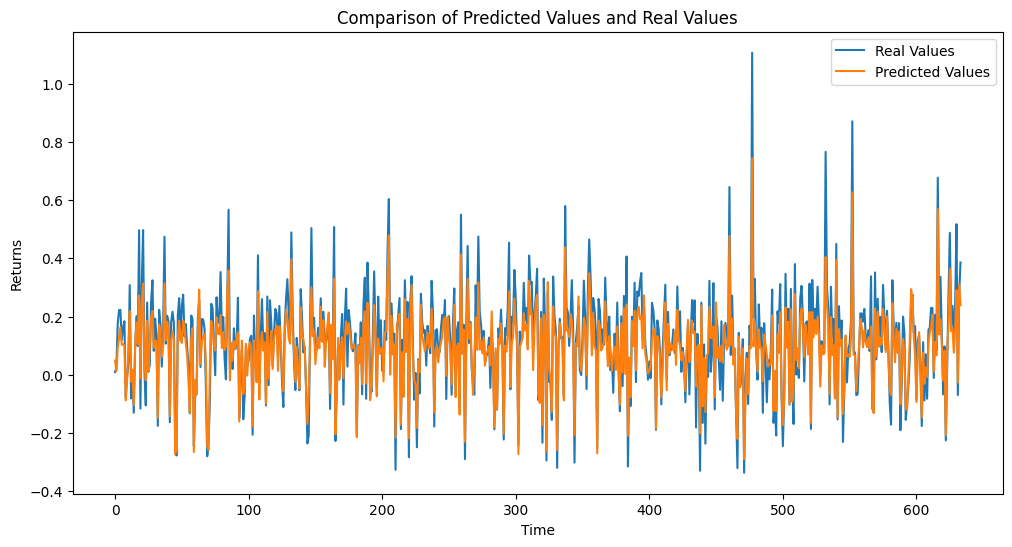

In [24]:
# Plot the graph comparing predicted values and real values
y_pred = model_bay_cnn_lstm.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(data2['real'], label='Real Values')
plt.plot(data2['pred'], label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Comparison of Predicted Values and Real Values')
plt.legend()
plt.show()

# **5.Market Timing with Deep Q-learning**

## Rescale Uncertainty
Since the uncertainty estimates are those of percentage returns, the uncertainty as seen from above are of a very smaller scale ($1e-13$), to make the uncertainty penalty to have effect in agent's learning, we are going to scale the uncertainty

In [ ]:
# Function to get states from your Bayesian CNN-LSTM model and incorporate uncertainty
def get_states():
    # create an extended state that incorporated uncertainty estimation
    # and the predictions
    # We limit the state size to 100*2
    # This is necessary to maintain consistency
    extended_state = np.concatenate((y_pred[:100,:], uncertainty[:100,:]), axis=1)
    return extended_state

In [5]:


# The DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size,uncertainty_penalty):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=200)  # Experience replay buffer
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration-exploitation trade-off
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.uncertainty_penalty=uncertainty_penalty
        self.model = self._build_model()

    def _huber_loss(self,y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = keras_b.abs(error) <= clip_delta

        squared_loss = 0.5 * keras_b.square(error)
        quadratic_loss = (
                    0.5 * keras_b.square(clip_delta) +
                    clip_delta * (keras_b.abs(error) - clip_delta)
                )

        return keras_b.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        model = Sequential()
        model.add(Flatten(input_shape=(state_size, 2)))  # Flatten layer to reshape input
        model.add(Dense(24, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(
            loss=self._huber_loss, 
            optimizer=Adam(learning_rate=self.learning_rate)
        )
        # model = Sequential()
        # model.add(Dense(24, activation='relu'))
        # model.add(Dense(24, activation='relu'))
        # model.add(Dense(self.action_size, activation='linear'))
        # model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        # print(state.shape)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state,current_holding=0):
        if np.random.rand() <= self.epsilon:
            # Randomly select action from the action space: short, do nothing, long
            return np.random.uniform(-1, 1)
        else:
            # Use the Q-network to select action based on state
            return np.argmax(self.model.predict(state,verbose=0)[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            # print(next_state.shape)
            if not done:
                # print(self.model.predict(next_state))
                target = reward + self.gamma * np.amax(self.model.predict(next_state,verbose=0)[0])
            # print(state.shape)
            target_f = self.model.predict(state,verbose=0)
            # print(action)
            target_f[0][0] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# The Market environment
class MarketEnvironment:
    def __init__(self,agent, max_episode_length=100, min_available_capital=10, max_trades=None, profit_target=None, stop_loss=-5000):
        self.state_size = state_size  # The actual size of your state
        self.action_size = 1  # Example: Buy, Sell, Hold
        self.initial_capital = 10000  # Initial available capital
        self.transaction_cost = 0.01  # Transaction charge (1%)
        self.current_capital = self.initial_capital
        self.max_episode_length = max_episode_length
        self.min_available_capital = min_available_capital
        self.max_trades = max_trades
        self.profit_target = profit_target
        self.stop_loss = stop_loss
        self.num_trades = 0
        self.total_reward = 0
        self.uncertainty_penalty=agent.uncertainty_penalty

    def reset(self):
        # Reset logic
        self.current_capital = self.initial_capital
        self.num_trades = 0
        self.total_reward = 0
        # print(self.state_size)
        return np.random.rand(self.state_size)

    def step(self, action,time_state):
        # Extract market returns and uncertainty from the state
        market_returns = time_state[0]  # First column contains predicted market returns
        uncertainty = time_state[1]     # Second column contains uncertainty estimations
        # Simulated step function, returns next_state, reward, done
        next_state = np.random.rand(self.state_size,2)

        # Calculate bet size based on the selected action
        bet_size = abs(action) * self.current_capital

        # Calculate transaction cost based on the bet size
        total_transaction_cost=self.transaction_cost * bet_size
        # Subtract the transaction cost
        self.current_capital -= total_transaction_cost
        # Calculate the return based on the market return and the direction of the trade
        # For a long position, return is market return * bet size
        # For not taking any position, return is 0
        if action > 0:
            return_direction = 1
        elif action<0:
            return_direction = -1
        else:
            return_direction = 0
        return_amount = return_direction * market_returns * bet_size
        yield_size=return_amount+bet_size
        if action > 0:
            # Adjust available capital based on bet size
            self.current_capital += return_amount
    
        # If action == 0, it means the agent wants to close the position
        elif action == 0:
            # Adjust available capital based on the current holding
            self.current_capital += return_amount
        # Calculate reward based on market return, transaction charges, and uncertainty
        reward = return_amount
        #Since the uncertainty is calculated from return predictions, 
        # The corresponding estimates take lower scales .i.e 1e-13
        # We have to scale this so that it can have effect on the reward
        # We scale by multiplying the uncertainty by 1e-11
        reward -= self.uncertainty_penalty * uncertainty*return_amount*1e-11 
        # Increment total reward
        self.total_reward += reward

        # Increment number of trades
        self.num_trades += 1
         # Check termination conditions
        done = False
        if self.num_trades >= self.max_episode_length:
            done = True
        elif self.current_capital <= self.min_available_capital:
            done = True
        elif self.max_trades is not None and self.num_trades >= self.max_trades:
            done = True
        elif self.profit_target is not None and self.total_reward >= self.profit_target:
            done = True
        elif self.stop_loss is not None and self.total_reward <= self.stop_loss:
            done = True
        return next_state, reward, done


In [49]:
# EPISODE LENGTH
# This is equivalent to the time steps we would want our agent to master
EPISODE_LENGTH=15
EPISODES=10

**Uncertainty penalty hyperparameter tuning**

In [50]:

# Hyperparameters
states=get_states()
state_size = states.size # The actual size of your state
print(state_size)
state_size=int(state_size/2) #The halfed state size for the input size
print(state_size)
action_size = 1  # Percentage defined as a ratio
batch_size = 32

# Define the uncertainty penalty range
param_grid = {'uncertainty_penalty': [0.9, 0.75, 0.5, 0.3, 0.1]}

best_score = -float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    # Create the environment and agent
    agent = DQNAgent(state_size, action_size,params['uncertainty_penalty'])
    env = MarketEnvironment(agent)
    total_rewards = []
    # Training the DQN agent
    for episode in range(EPISODES):  # Replace with the desired number of episodes
        state = env.reset()
        state_from_cnn_lstm = get_states()
        # state=state_from_lstm
        state = np.reshape(state_from_cnn_lstm, [1, state_size, 2])
        # print(state)
        total_episode_reward = 0  # Initialize total reward for the episode
    
        for time in range(EPISODE_LENGTH):  # Replace with the desired episode length
            action = agent.act(state)
            # print(market_returns_array[time])
            # Get this time state for reward calculation
            # print(state.shape)
            time_state=state[0][time]
            # print(time_state,time,episode)
            next_state, reward, done = env.step(action,time_state)
            next_state = np.reshape(next_state, [1, state_size, 2])
            # print(state.shape)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_episode_reward += reward  # Accumulate the reward obtained at each time step
            total_rewards.append(total_episode_reward)
            if done:
                print("Episode: {}/{}, Reward score: {}".format(episode+1, EPISODES, total_episode_reward))
                break
            # print(batch_size)
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
    # Evaluate the performance of the agent
    score = np.mean(total_rewards) 
    print("Uncertainty penalty score: ",score, "penalty: ",params)
    if score > best_score:
        best_score = score
        best_params = params

print("Best Uncertainty Penalty:", best_params['uncertainty_penalty'])



200
100
Episode: 1/10, Reward score: -6063.004422030691
Episode: 2/10, Reward score: -9549.968468211388
Episode: 3/10, Reward score: -6249.005491661543
Episode: 4/10, Reward score: -5644.07216466267
Episode: 6/10, Reward score: -7177.048804268092
Episode: 7/10, Reward score: -16384.20121454646
Episode: 9/10, Reward score: -7317.455371579456
Episode: 10/10, Reward score: -8345.370684839507
Uncertainty penalty score:  4204.519619832204 penalty:  {'uncertainty_penalty': 0.9}
Episode: 1/10, Reward score: -6036.133147831693
Episode: 3/10, Reward score: -5519.215342364594
Episode: 4/10, Reward score: -6300.47037813598
Episode: 5/10, Reward score: -8776.409181064242
Episode: 6/10, Reward score: -6697.44400869162
Uncertainty penalty score:  7535.5712751618885 penalty:  {'uncertainty_penalty': 0.75}
Episode: 2/10, Reward score: -8316.891145499534
Episode: 3/10, Reward score: -8858.035469048631
Episode: 4/10, Reward score: -18439.884345961273
Episode: 5/10, Reward score: -9026.576022273068
Episo

In [51]:
UNCERTAINTY_PENALTY=best_params['uncertainty_penalty']

In [55]:
UNCERTAINTY_PENALTY

0.75

**Episode length hyperparameter tuning**

In [59]:

# Hyperparameters
states=get_states()
state_size = states.size # The actual size of your state
print(state_size)
state_size=int(state_size/2) #The halfed state size for the input size
print(state_size)
action_size = 1  # Percentage defined as a ratio
batch_size = 32

# Define the uncertainty penalty range
episode_length_param_grid = {'episode_length': [10, 15, 20, 30, 40]}

episode_length_best_score = -float('inf')
episode_length_best_params = None

for params in ParameterGrid(episode_length_param_grid):
    # Create the environment and agent
    agent = DQNAgent(state_size, action_size,UNCERTAINTY_PENALTY)
    env = MarketEnvironment(agent)
    total_rewards = []
    # Training the DQN agent
    for episode in range(EPISODES):  # Replace with the desired number of episodes
        state = env.reset()
        state_from_cnn_lstm = get_states()
        # state=state_from_lstm
        state = np.reshape(state_from_cnn_lstm, [1, state_size, 2])
        # print(state)
        total_episode_reward = 0  # Initialize total reward for the episode
    
        for time in range(params['episode_length']):  # Replace with the desired episode length
            action = agent.act(state)
            # print(market_returns_array[time])
            # Get this time state for reward calculation
            # print(state.shape)
            time_state=state[0][time]
            # print(time_state,time,episode)
            next_state, reward, done = env.step(action,time_state)
            next_state = np.reshape(next_state, [1, state_size, 2])
            # print(state.shape)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_episode_reward += reward  # Accumulate the reward obtained at each time step
            total_rewards.append(total_episode_reward)
            if done:
                print("Episode: {}/{}, Reward score: {}".format(episode+1, EPISODES, total_episode_reward))
                break
            # print(batch_size)
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
    # Evaluate the performance of the agent
    score = np.mean(total_rewards) 
    print("episode length score: ",score, "episode-length: ",params)
    if score > episode_length_best_score:
        episode_length_best_score = score
        episode_length_best_params = params

print("Best episode length:", episode_length_best_params['episode_length'])



200
100
Episode: 3/10, Reward score: -7514.893878450878
Episode: 4/10, Reward score: -8108.414768822121
Episode: 5/10, Reward score: -5002.517206079981
Episode: 6/10, Reward score: -6003.914790995475
Episode: 9/10, Reward score: -6065.874533365453
Episode: 10/10, Reward score: -7246.977624097467
episode length score:  4002.8863985294756 episode-length:  {'episode_length': 10}
Episode: 1/10, Reward score: -5948.90192312534
Episode: 3/10, Reward score: -5071.162159959938
Episode: 4/10, Reward score: -6632.867495846647
Episode: 5/10, Reward score: -6543.584676820699
Episode: 6/10, Reward score: -8726.490057497624
Episode: 7/10, Reward score: -6304.366075618569
episode length score:  2618.5309011803297 episode-length:  {'episode_length': 15}
Episode: 1/10, Reward score: -23131.83133804807
Episode: 2/10, Reward score: -7789.075528426594
Episode: 3/10, Reward score: -5239.871150720246
Episode: 4/10, Reward score: -7742.736424340098
Episode: 5/10, Reward score: -9055.207442352337
Episode: 6/1

In [60]:
EPISODE_LENGTH=episode_length_best_params['episode_length']

In [63]:
EPISODE_LENGTH

30

**Number of episodes hyperparameter tuning**

In [64]:

# Hyperparameters
states=get_states()
state_size = states.size # The actual size of your state
print(state_size)
state_size=int(state_size/2) #The halfed state size for the input size
print(state_size)
action_size = 1  # Percentage defined as a ratio
batch_size = 32

# Define the uncertainty penalty range
episodes_param_grid = {'episodes': [10, 15, 20, 30, 40]}

episodes_best_score = -float('inf')
episodes_best_params = None

for params in ParameterGrid(episodes_param_grid):
    # Create the environment and agent
    agent = DQNAgent(state_size, action_size,UNCERTAINTY_PENALTY)
    env = MarketEnvironment(agent)
    total_rewards = []
    # Training the DQN agent
    for episode in range(params['episodes']):  # Replace with the desired number of episodes
        state = env.reset()
        state_from_cnn_lstm = get_states()
        # state=state_from_lstm
        state = np.reshape(state_from_cnn_lstm, [1, state_size, 2])
        # print(state)
        total_episode_reward = 0  # Initialize total reward for the episode
    
        for time in range(EPISODE_LENGTH):  # Replace with the desired episode length
            action = agent.act(state)
            # print(market_returns_array[time])
            # Get this time state for reward calculation
            # print(state.shape)
            time_state=state[0][time]
            # print(time_state,time,episode)
            next_state, reward, done = env.step(action,time_state)
            next_state = np.reshape(next_state, [1, state_size, 2])
            # print(state.shape)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_episode_reward += reward  # Accumulate the reward obtained at each time step
            total_rewards.append(total_episode_reward)
            if done:
                print("Episode: {}/{}, Reward score: {}".format(episode+1, params['episodes'], total_episode_reward))
                break
            # print(batch_size)
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
    # Evaluate the performance of the agent
    score = np.mean(total_rewards) 
    print("episodes score: ",score, "episodes: ",params)
    if score > episodes_best_score:
        episodes_best_score = score
        episodes_best_params = params

print("Best episodes:", episodes_best_params['episodes'])



200
100
Episode: 1/10, Reward score: -9547.92099764064
Episode: 2/10, Reward score: -19491.130564957613
Episode: 3/10, Reward score: -10024.751589229536
Episode: 4/10, Reward score: -7385.885488918299
Episode: 5/10, Reward score: -8483.297983061668
Episode: 6/10, Reward score: -30961.85001328421
Episode: 7/10, Reward score: -7857.853122130756
Episode: 8/10, Reward score: -5147.040591645058
Episode: 9/10, Reward score: -10872.52056523765
Episode: 10/10, Reward score: -5922.218908031953
episodes score:  8424.47220231185 episodes:  {'episodes': 10}
Episode: 1/15, Reward score: -13992.268093297731
Episode: 2/15, Reward score: -6396.056280473265
Episode: 3/15, Reward score: -7684.243311604362
Episode: 4/15, Reward score: -7917.077313554495
Episode: 5/15, Reward score: -12059.955229965899
Episode: 6/15, Reward score: -5081.67413356974
Episode: 7/15, Reward score: -6178.671453084802
Episode: 8/15, Reward score: -7858.8943850660435
Episode: 9/15, Reward score: -5746.677012941835
Episode: 10/15

In [65]:
EPISODES=episodes_best_params['episodes']

**Best hyperparameters**
- EPISODES=40
- EPISODE_LENGTH=30
- UNCERTAINTY_PENALTY=0.75

In [6]:
EPISODES=40
EPISODE_LENGTH=30
UNCERTAINTY_PENALTY=0.75

In [66]:
# Hyperparameters
states=get_states()
state_size = states.size # The actual size of your state
print(state_size)
state_size=int(state_size/2) #The halfed state size for the input size
print(state_size)
action_size = 1  # Percentage defined as a ratio
batch_size = 32
# # market return

# Create the environment and agent
agent = DQNAgent(state_size, action_size, UNCERTAINTY_PENALTY)
env = MarketEnvironment(agent)



# Training the DQN agent
for episode in range(EPISODES):  # Replace with the desired number of episodes
    state = env.reset()
    state_from_cnn_lstm = get_states()
    # state=state_from_lstm
    state = np.reshape(state_from_cnn_lstm, [1, state_size, 2])
    # print(state)
    total_episode_reward = 0  # Initialize total reward for the episode

    for time in range(EPISODE_LENGTH):  # Replace with the desired episode length
        action = agent.act(state)
        # print(market_returns_array[time])
        # Get this time state for reward calculation
        # print(state.shape)
        time_state=state[0][time]
        # print(time_state,time,episode)
        next_state, reward, done = env.step(action,time_state)
        next_state = np.reshape(next_state, [1, state_size, 2])
        # print(state.shape)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_episode_reward += reward  # Accumulate the reward obtained at each time step
        if done:
            print("Episode: {}/{}, Reward score: {}".format(episode+1, EPISODES, total_episode_reward))
            break
        # print(batch_size)
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

200
100
Episode: 1/40, Reward score: -5165.778725524984
Episode: 2/40, Reward score: -10948.498673451631
Episode: 3/40, Reward score: -9786.253994051967
Episode: 4/40, Reward score: -68681.48103538027
Episode: 6/40, Reward score: -6552.179274709281
Episode: 7/40, Reward score: -9346.62403099326
Episode: 8/40, Reward score: -23157.585012660704
Episode: 9/40, Reward score: -8271.590287196754
Episode: 10/40, Reward score: -16941.948463074146
Episode: 11/40, Reward score: -6773.583091827699
Episode: 12/40, Reward score: -24950.99464415438
Episode: 15/40, Reward score: -5382.734334431651
Episode: 17/40, Reward score: -6279.206142442916
Episode: 19/40, Reward score: -6527.869466981507
Episode: 20/40, Reward score: -5345.633362981011
Episode: 21/40, Reward score: -8393.963089852923
Episode: 24/40, Reward score: -5504.270658906927
Episode: 28/40, Reward score: -8336.709180996391
Episode: 29/40, Reward score: -8419.436740012698
Episode: 36/40, Reward score: -11669.669611192789


## Save model weights

In [67]:
# Save DQNAgent object weights
agent.model.save_weights('trained_qql_weights.h5')
# Assuming your agent is called 'agent'


# Save the agent's configurations using pickle
agent_config = {
    'state_size': agent.state_size,
    'action_size': agent.action_size,
    # Add any other relevant configurations of your agent here
}
print(agent_config)
with open("trained_qql_agent_config.pkl", "wb") as config_file:
    pickle.dump(agent_config, config_file)

{'state_size': 100, 'action_size': 1}


# **Backtest the models**

**Collect market data**

In [68]:
# Define the start and end dates for the live market data
start_date_live = '2023-01-01'
end_date_live = '2024-01-31'

# Fetch the data using the Yahoo Finance API
apple_data_live = yf.download('AAPL', start=start_date_live, end=end_date_live)
# Display the first few rows of the data
print(apple_data_live.head())
apple_data_live.to_csv("apple_stock_prices_live.csv")

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  130.279999  130.899994  124.169998  125.070000  124.216301   
2023-01-04  126.889999  128.660004  125.080002  126.360001  125.497498   
2023-01-05  127.129997  127.769997  124.760002  125.019997  124.166641   
2023-01-06  126.010002  130.289993  124.889999  129.619995  128.735245   
2023-01-09  130.470001  133.410004  129.889999  130.149994  129.261627   

               Volume  
Date                   
2023-01-03  112117500  
2023-01-04   89113600  
2023-01-05   80962700  
2023-01-06   87754700  
2023-01-09   70790800  


In [7]:
# Load the data from the CSV file
data_live = pd.read_csv("apple_stock_prices_live.csv")


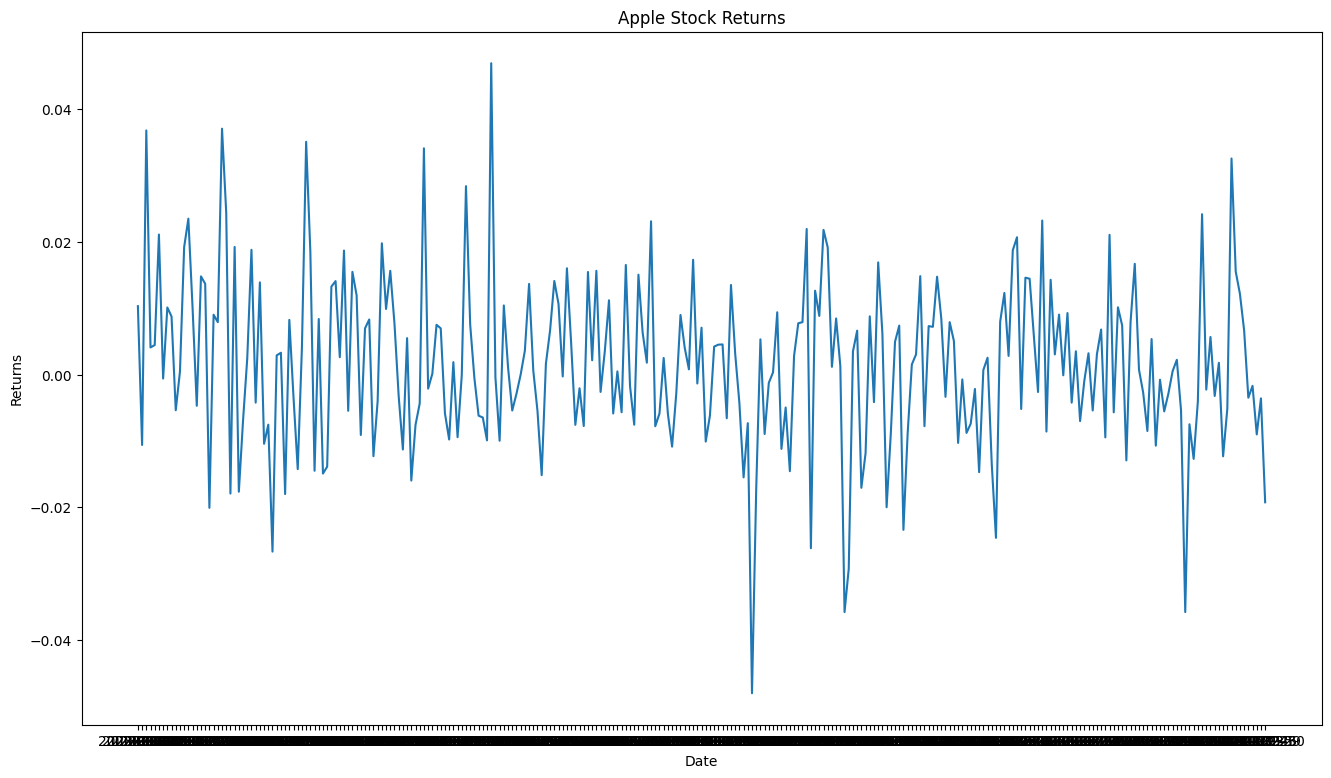

In [8]:
# Calculate the returns
data_live['Returns'] = data_live['Adj Close'].pct_change()


# Drop rows with missing values (NaNs) resulting from the shifting
data_live.dropna(inplace=True)
# Create the line plot
plt.plot(data_live["Date"], data_live["Returns"])
plt.title("Apple Stock Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()

**Preprocess for Bayesian CNN-LSTM predictions**

In [9]:
X_live = []
y_live = []
window_size=100
for i in range(1 , len(data_live) - window_size -1 , 1):
    first = data_live.iloc[i,5]
    # print(first)
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((data_live.iloc[i + j, 5] - first) / first)
    temp2.append((data_live.iloc[i + window_size, 5] - first) / first)
    X_live.append(np.array(temp).reshape(100, 1))
    y_live.append(np.array(temp2).reshape(1, 1))


X_live = np.array(X_live)
y_live = np.array(y_live)
# # Reshape the input data for CNN (channels last)
X_live = X_live.reshape(X_live.shape[0],1,100,1)

print(len(X_live))
print(len(y_live))

167
167


In [ ]:
# X_live

**Load the trained and saved Bayesian CNN-LSTM model**

In [10]:
# Load the saved model
loaded_bay_cnn_lstm_model = load_model('complete_bayesian_cnn_lstm.h5')

**Make Bayesian CNN-LSTM predictions**

6/6 [==============================] - 3s 14ms/step

6/6 [==============================] - 3s 24ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0482
Prediction loss: [0.0037900698371231556, 0.0037900698371231556, 0.048176851123571396]


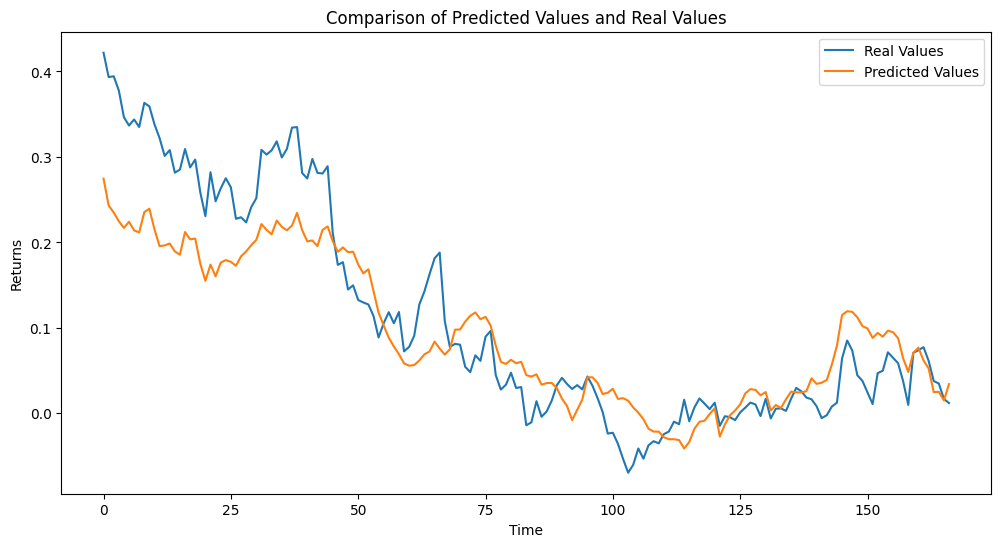

In [11]:
# Plot the graph comparing predicted values and real values
y_pred_live = loaded_bay_cnn_lstm_model.predict(X_live)
pred_loss = loaded_bay_cnn_lstm_model.evaluate(X_live, y_live)
print("Prediction loss:", pred_loss)
y_live_list=[]
for i in y_live:
    y_live_list.append(i[0][0])
data_live_2=pd.DataFrame(y_pred_live,columns=["pred"])
data_live_2["real"]=y_live_list  
plt.figure(figsize=(12, 6))
plt.plot(data_live_2['real'], label='Real Values')
plt.plot(data_live_2['pred'], label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Comparison of Predicted Values and Real Values')
plt.legend()
plt.show()

**Estimate uncertainty**

In [14]:
num_predictions_live = 100
predictions_live = []

for _ in range(num_predictions_live):
    enable_dropout(loaded_bay_cnn_lstm_model)
    pred = loaded_bay_cnn_lstm_model.predict(X_live,verbose=0) 
    predictions_live.append(pred)

predictions_live = np.array(predictions_live)


**Aggregate uncertianty**

In [15]:
mean_prediction_live = np.mean(predictions_live, axis=0)
uncertainty_live = np.var(predictions_live, axis=0)

In [ ]:
uncertainty_live

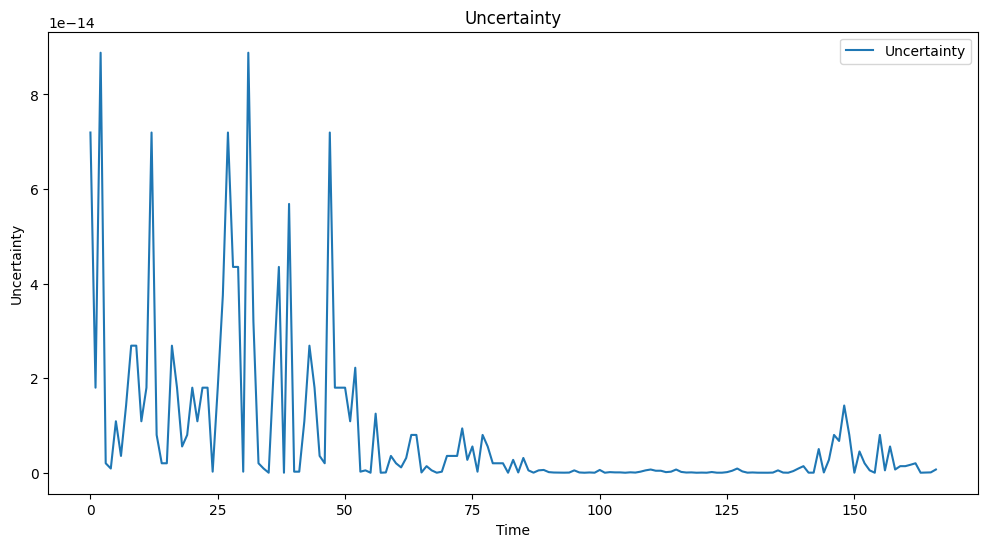

In [16]:
# uncertainty

plt.figure(figsize=(12, 6))
plt.plot(uncertainty_live, label='Uncertainty')
plt.xlabel('Time')
plt.ylabel('Uncertainty')
plt.title('Uncertainty')
plt.legend()
plt.show()

In [ ]:
y_pred_live.shape


**Load the Deep Q-learning weights**

In [32]:
# Function to get states from your Bayesian CNN-LSTM model and incorporate uncertainty
def get_states_live():
    # create an extended state that incorporated uncertainty estimation
    # and the predictionsd
    extended_state = np.concatenate(
        (y_pred_live[:100,:], 
         uncertainty_live[:100,:]),
        axis=1
    )
    return extended_state


# # Hyperparameters
states=get_states_live()
state_size = states.size # The actual size of your state
state_size=int(state_size/2) #The halfed state size for the input size
print(state_size)
action_size = 1  # Percentage defined as a ratio
batch_size = 32
# market return
# Load trained model weights
loaded_dqq_agent = DQNAgent(state_size, action_size,UNCERTAINTY_PENALTY)
loaded_dqq_agent.model.load_weights('trained_qql_weights.h5')

100


**Make bet size predictions**

In [39]:

# Predict actions (sizes of bets)
actions_live = []
for state in states:
    action = loaded_dqq_agent.act(state)
    actions_live.append(action)

# print("Predicted actions:", actions_live)

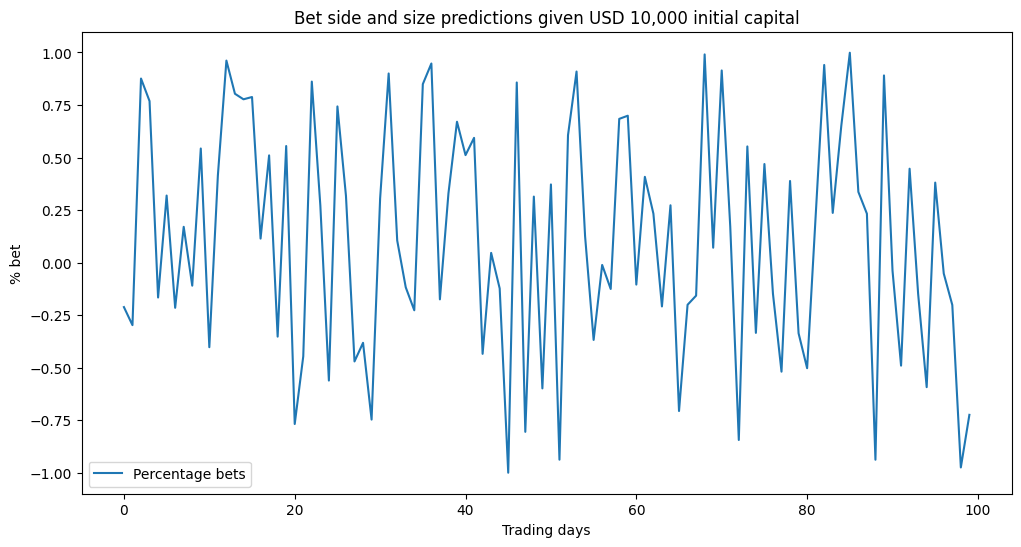

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(actions_live, label='Percentage bets')
plt.xlabel('Trading days')
plt.ylabel('% bet')
plt.title('Bet side and size predictions given USD 10,000 initial capital')
plt.legend()
plt.show()

In [58]:
def evaluate_actions(actions, market_returns, initial_capital=10000,num_trades=10):
    """
    Evaluate the performance of actions in the market.

    Args:
    - actions (list): List of actions taken by the agent (sizes of bets).
    - market_returns (numpy.ndarray): Array of actual market returns.
    - initial_capital (float): Initial capital for trading. Default is 10000.

    Returns:
    - cumulative_return (float): Cumulative return after trading.
    """
    capital = initial_capital
    num_trades = num_trades
    total_return = 0
    profit_loss=[]
    cum_capital=[]
    cum_capital.append(initial_capital)
    profit_loss.append(0)
    for i, action in enumerate(actions):
        if i>num_trades:
            break
        # Calculate bet size based on the selected action
        bet_size = abs(action) * capital

        # Calculate transaction cost based on the bet size (assuming 1% transaction cost)
        transaction_cost = 0.01 * bet_size

        # Subtract transaction cost from capital
        capital -= transaction_cost
        # Calculate the return based on the market return and the direction of the trade
        # For a long position, return is market return * bet size
        # For not taking any position, return is 0
        if action > 0:
            return_direction = 1
        elif action<0:
            return_direction = -1
        else:
            return_direction = 0
        return_amount = return_direction * market_returns[i][0][0] * bet_size
        profit_loss.append(return_amount)
        # Calculate yield size (bet size + market return amount)
        # print("Action=",action)
        # print("bet_size=",bet_size)
        # print("Market return",market_returns[i][0][0])
        yield_size = return_amount + bet_size
        # print("Return amount=",return_amount)
        # print("yield_size=",yield_size)
        
        # Update capital and holding based on action
        if action > 0:
            # Going long
            capital += return_amount
        elif action < 0:
            # Going short
            capital += return_amount

        # Increment total reward
        total_return += return_amount
        cum_capital.append(capital)
    # Calculate cumulative return
    cumulative_return = ((total_return)/initial_capital)*100

    return total_return,cumulative_return,num_trades,profit_loss,cum_capital

In [59]:
cum_reward=evaluate_actions(
    actions=actions_live,
    market_returns=y_live,
    num_trades=10
)

In [60]:
len(cum_reward[3])

12

In [61]:
len(cum_reward[4])

12

In [62]:
data_live_4=pd.DataFrame(cum_reward[4],columns=["Capital"])
data_live_4['profit']=cum_reward[3]
data_live_4.head()

,Capital,profit
0,10000.000000,0.000000
1,9087.277664,-891.589704
2,7997.720271,-1062.549034
3,10690.089239,2762.415694
4,13710.352394,3102.408912


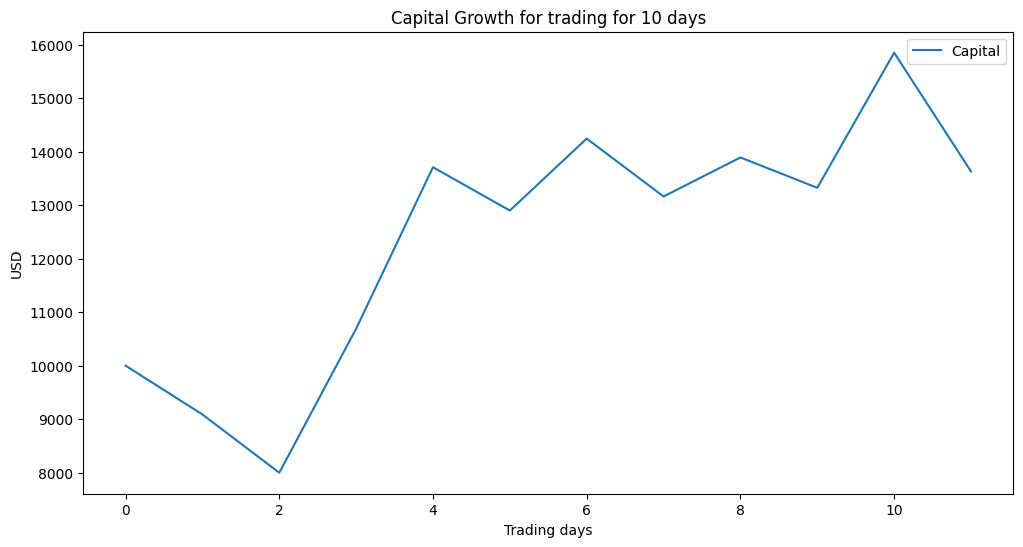

In [63]:

plt.figure(figsize=(12, 6))
plt.plot(data_live_4['Capital'], label='Capital')
plt.xlabel('Trading days')
plt.ylabel('USD')
plt.title('Capital Growth for trading for 10 days')
plt.legend()
plt.show()

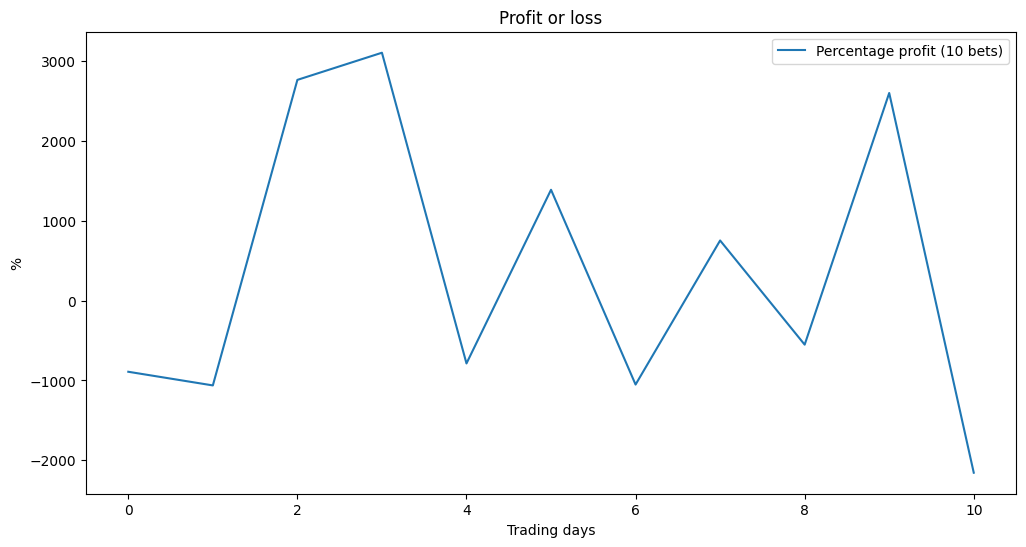

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(data_live_3['profit'], label='Percentage profit (10 bets)')
plt.xlabel('Trading days')
plt.ylabel('%')
plt.title('Profit or loss')
plt.legend()
plt.show()

In [65]:
print(
    f"Total profit = {cum_reward[0]}",
    f"%-profit = {cum_reward[1]}",
    f"Total trades = {cum_reward[2]}"
    )

Total profit = 4100.65129072707 %-profit = 41.0065129072707 Total trades = 10


**Agents performance based on number of trades allowed to place**

In [66]:
num_trades_profits=[]
num_trades_percentage_profits=[]
num_trades_cum_reward=[]
for i in range(1,101):
    cum_reward_=evaluate_actions(
        actions=actions_live,
        market_returns=y_live,
        num_trades=i
    )
    num_trades_profits.append(cum_reward_[0])
    num_trades_percentage_profits.append(cum_reward_[1])
    #Get the cummulative capital on the last trading day
    num_trades_cum_reward.append(cum_reward_[4][-1])

In [67]:
trade_data={
    "profit":num_trades_profits,
    "percentage_profit":num_trades_percentage_profits,
    "capital":num_trades_cum_reward
}
data_live_5=pd.DataFrame(trade_data)


In [68]:
data_live_5.head(10)

,profit,percentage_profit,capital
0,-1954.138739,-19.541387,7997.720271
1,808.276956,8.082770,10690.089239
2,3910.685867,39.106859,13710.352394
3,3123.213387,31.232134,12900.147327
4,4509.934719,45.099347,14245.690922
5,3458.147166,34.581472,13163.313908
6,4210.003584,42.100036,13892.730357
7,3657.817458,36.578175,13325.343013
8,6256.113527,62.561135,15851.280882
9,4100.651291,41.006513,13632.068928


In [69]:
data_live_5.tail(10)

,profit,percentage_profit,capital
90,65974.558013,659.745580,55313.672747
91,66679.617172,666.796172,55771.533908
92,66405.577536,664.055775,55414.648817
93,65484.135482,654.841355,54165.056098
94,66374.011268,663.740113,54848.662237
95,66282.135669,662.821357,54728.335955
96,66085.458594,660.854586,54421.460483
97,66004.787013,660.047870,53810.673991
98,66924.527279,669.245273,54340.904405
99,66924.527279,669.245273,54340.904405


In [70]:
data_live_5.describe()

,profit,percentage_profit,capital
count,100.000000,100.000000,100.000000
mean,48667.380755,486.673808,48741.286118
std,22806.859535,228.068595,17488.590802
min,-1954.138739,-19.541387,7997.720271
25%,30497.879862,304.978799,37347.147885
50%,59533.747939,595.337479,55364.160782
75%,66163.825686,661.638257,58871.838426
max,86931.182176,869.311822,90367.524775


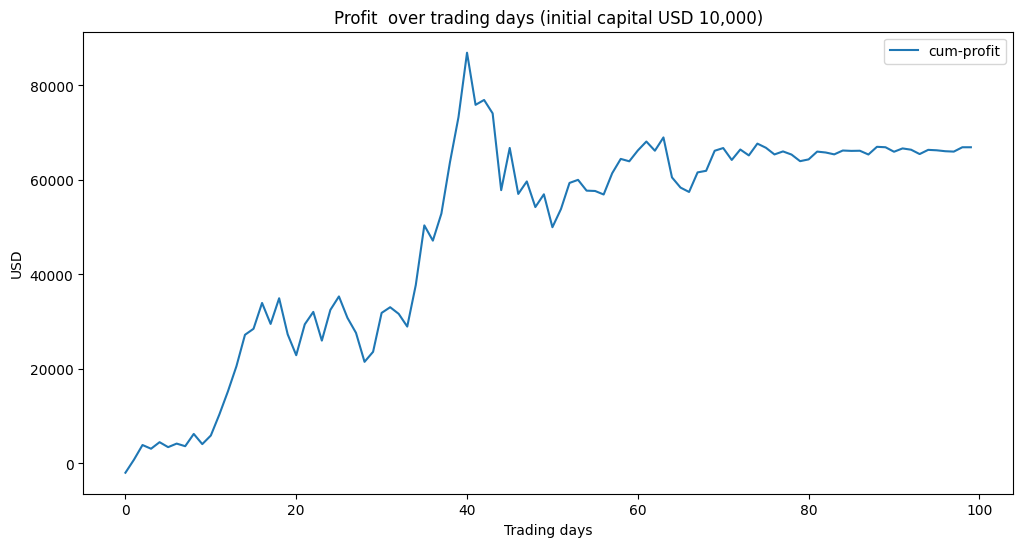

In [71]:

plt.figure(figsize=(12, 6))
plt.plot(data_live_5['profit'], label="cum-profit")
plt.xlabel('Trading days')
plt.ylabel('USD')
plt.title('Profit  over trading days (initial capital USD 10,000)')
plt.legend()
plt.show()

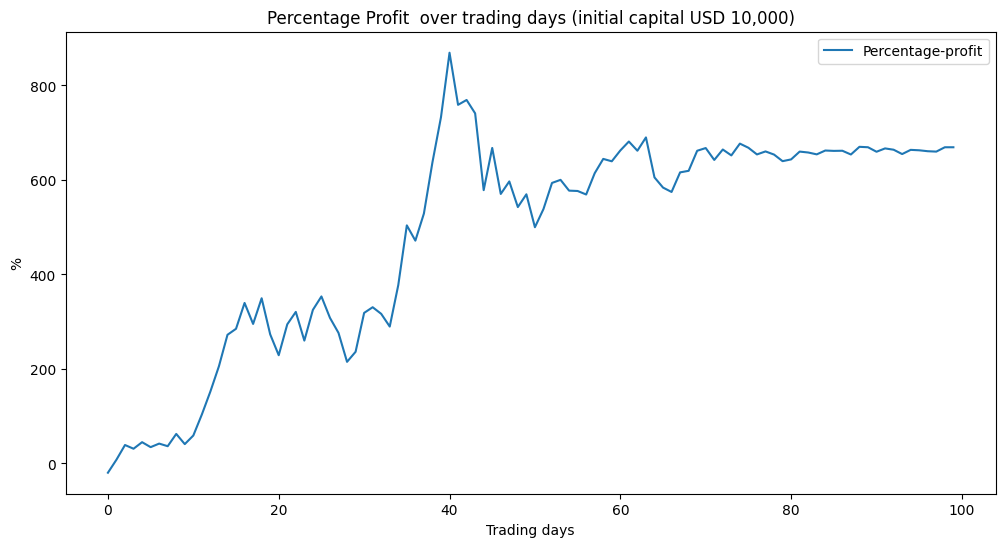

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(data_live_5['percentage_profit'], label="Percentage-profit")
plt.xlabel('Trading days')
plt.ylabel('%')
plt.title('Percentage Profit  over trading days (initial capital USD 10,000)')
plt.legend()
plt.show()

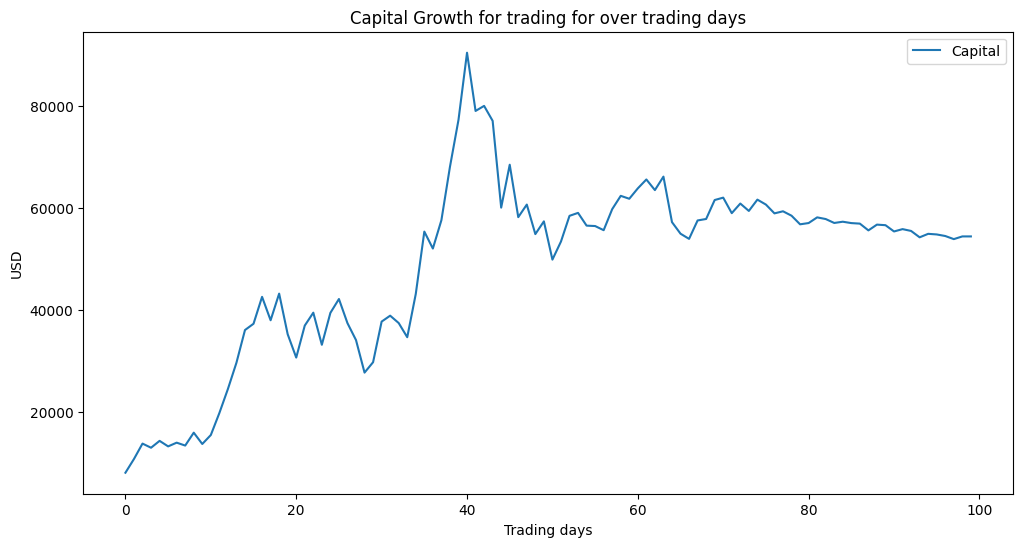

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(data_live_5['capital'], label='Capital')
plt.xlabel('Trading days')
plt.ylabel('USD')
plt.title('Capital Growth for trading for over trading days')
plt.legend()
plt.show()

# 6. Market timing using Q-learning agent without uncertainty (CNN-LSTM Q-learning)

In [74]:
# Function to get states from your Bayesian CNN-LSTM model and incorporate uncertainty
def get_states_cnn_lstm():
    # We limit the state size to 100*2
    # This is necessary to maintain consistency
    return y_pred[:100,:]

In [106]:
# The DQN agent
class DQNAgentCNNLSTM:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=200)  # Experience replay buffer
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration-exploitation trade-off
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _huber_loss(self,y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = keras_b.abs(error) <= clip_delta

        squared_loss = 0.5 * keras_b.square(error)
        quadratic_loss = (
                    0.5 * keras_b.square(clip_delta) +
                    clip_delta * (keras_b.abs(error) - clip_delta)
                )

        return keras_b.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        model = Sequential()
        model.add(Flatten(input_shape=(state_size,1)))  # Flatten layer to reshape input
        model.add(Dense(24, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(
            loss=self._huber_loss, 
            optimizer=Adam(learning_rate=self.learning_rate)
        )
        # model = Sequential()
        # model.add(Dense(24, activation='relu'))
        # model.add(Dense(24, activation='relu'))
        # model.add(Dense(self.action_size, activation='linear'))
        # model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        # print(state.shape)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state,current_holding=0):
        if np.random.rand() <= self.epsilon:
            # Randomly select action from the action space: short, do nothing, long
            return np.random.uniform(-1, 1)
        else:
            # Use the Q-network to select action based on state
            return np.argmax(self.model.predict(state,verbose=0)[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            # print(next_state.shape)
            if not done:
                # print(self.model.predict(next_state))
                target = reward + self.gamma * np.amax(self.model.predict(next_state,verbose=0)[0])
            # print(state.shape)
            target_f = self.model.predict(state,verbose=0)
            # print(target_f)
            target_f[0][0] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# The Market environment
class MarketEnvironmentCNNLSTM:
    def __init__(self, max_episode_length=100, min_available_capital=10, max_trades=None, profit_target=None, stop_loss=-5000):
        self.state_size = state_size  # The actual size of your state
        self.action_size = 1  # Example: Buy, Sell, Hold
        self.initial_capital = 10000  # Initial available capital
        self.transaction_cost = 0.01  # Transaction charge (1%)
        self.current_capital = self.initial_capital
        self.max_episode_length = max_episode_length
        self.min_available_capital = min_available_capital
        self.max_trades = max_trades
        self.profit_target = profit_target
        self.stop_loss = stop_loss
        self.num_trades = 0
        self.total_reward = 0

    def reset(self):
        # Reset logic
        self.current_capital = self.initial_capital
        self.num_trades = 0
        self.total_reward = 0
        # print(self.state_size)
        return np.random.rand(self.state_size)

    def step(self, action,time_state):
        # Extract market returns and uncertainty from the state
        # print(time_state)
        market_returns = time_state  # First column contains predicted market returns
        # Simulated step function, returns next_state, reward, done
        next_state = np.random.rand(self.state_size)

        # Calculate bet size based on the selected action
        bet_size = abs(action) * self.current_capital

        # Calculate transaction cost based on the bet size
        total_transaction_cost=self.transaction_cost * bet_size
        # Subtract the transaction cost
        self.current_capital -= total_transaction_cost
        # Calculate the return based on the market return and the direction of the trade
        # For a long position, return is market return * bet size
        # For not taking any position, return is 0
        if action > 0:
            return_direction = 1
        elif action<0:
            return_direction = -1
        else:
            return_direction = 0
        return_amount = return_direction * market_returns * bet_size
        yield_size=return_amount+bet_size
        if action > 0:
            # Adjust available capital based on bet size
            self.current_capital += return_amount
    
        # If action == 0, it means the agent wants to close the position
        elif action == 0:
            # Adjust available capital based on the current holding
            self.current_capital += return_amount
        # Calculate reward based on market return, transaction charges, and uncertainty
        reward = return_amount
        # Increment total reward
        self.total_reward += reward

        # Increment number of trades
        self.num_trades += 1
         # Check termination conditions
        done = False
        if self.num_trades >= self.max_episode_length:
            done = True
        elif self.current_capital <= self.min_available_capital:
            done = True
        elif self.max_trades is not None and self.num_trades >= self.max_trades:
            done = True
        elif self.profit_target is not None and self.total_reward >= self.profit_target:
            done = True
        elif self.stop_loss is not None and self.total_reward <= self.stop_loss:
            done = True
        return next_state, reward, done


In [107]:
# Hyperparameters
states=get_states_cnn_lstm()
state_size = states.size # The actual size of your state
print(state_size)
state_size=int(state_size) #The halfed state size for the input size
print(state_size)
action_size = 1  # Percentage defined as a ratio
batch_size = 32
# # market return

# Create the environment and agent
env_cnn_lstm = MarketEnvironmentCNNLSTM()
agent_cnn_lstm = DQNAgentCNNLSTM(state_size, action_size)


# Training the DQN agent
for episode in range(EPISODES):  # Replace with the desired number of episodes
    state = env_cnn_lstm.reset()
    state_from_cnn_lstm = get_states_cnn_lstm()
    # print(state_from_cnn_lstm)
    # state=state_from_lstm
    state = np.reshape(state_from_cnn_lstm, [1, state_size])
    # print(state)
    total_episode_reward = 0  # Initialize total reward for the episode

    for time in range(EPISODE_LENGTH):  # Replace with the desired episode length
        action = agent_cnn_lstm.act(state)
        # print(market_returns_array[time])
        # Get this time state for reward calculation
        # print(state.shape)
        time_state=state[0][time]
        # print(time_state,time,episode)
        next_state, reward, done = env_cnn_lstm.step(action,time_state)
        # print(next_state)
        next_state = np.reshape(next_state, [1, state_size])
        # print(state.shape)
        agent_cnn_lstm.remember(state, action, reward, next_state, done)
        state = next_state
        total_episode_reward += reward  # Accumulate the reward obtained at each time step
        if done:
            print("Episode: {}/{}, Reward score: {}".format(episode+1, EPISODES, total_episode_reward))
            break
        # print(batch_size)
        if len(agent_cnn_lstm.memory) > batch_size:
            agent_cnn_lstm.replay(batch_size)

100
100
Episode: 1/40, Reward score: -36871.98952942268
Episode: 2/40, Reward score: -12170.662096548587
Episode: 3/40, Reward score: -12813.00177065847
Episode: 4/40, Reward score: -5149.315819545296
Episode: 6/40, Reward score: -5128.402012851954
Episode: 8/40, Reward score: -17054.583679573716
Episode: 9/40, Reward score: -8281.370434107723
Episode: 10/40, Reward score: -9740.887670889972
Episode: 11/40, Reward score: -10346.754375778024
Episode: 12/40, Reward score: -5713.344204921372
Episode: 13/40, Reward score: -10176.861175254373
Episode: 14/40, Reward score: -8385.642194472843
Episode: 16/40, Reward score: -6551.540690034107
Episode: 17/40, Reward score: -10330.044298475048
Episode: 18/40, Reward score: -11834.796042148664
Episode: 19/40, Reward score: -10068.3586808166
Episode: 21/40, Reward score: -7848.39345192342
Episode: 22/40, Reward score: -5783.931098163715
Episode: 24/40, Reward score: -6090.32888460011
Episode: 25/40, Reward score: -6016.371569186742
Episode: 26/40, 

**Save the cnn-lstm Q-learning agent model**

In [108]:
# Save DQNAgent object weights
agent_cnn_lstm.model.save_weights('trained_qql_weights_cnn_lstm.h5')
# Assuming your agent is called 'agent'


# Save the agent's configurations using pickle
agent_cnn_lstm_config = {
    'state_size': agent_cnn_lstm.state_size,
    'action_size': agent_cnn_lstm.action_size,
    # Add any other relevant configurations of your agent here
}
print(agent_cnn_lstm_config)
with open("trained_qql_agent_config_cnn_lstm.pkl", "wb") as config_file:
    pickle.dump(agent_cnn_lstm_config, config_file)

{'state_size': 100, 'action_size': 1}


## **Backtest CNN-LSTM Q-learning agent**

**load CNN-LSTM Q-learning agent**

In [111]:
# Function to get states from your CNN-LSTM model
def get_states_live_cnn_lstm():
    # We use the predictions from Bayesian  CNN-LSTM without the Uncertainty estimates
    return y_pred_live[:100,:]


# # Hyperparameters
states=get_states_live_cnn_lstm()
state_size = states.size # The actual size of your state
state_size=int(state_size) #The halfed state size for the input size
print(state_size)
action_size = 1  # Percentage defined as a ratio
batch_size = 32
# market return
# Load trained model weights
loaded_dqq_agent_cnn_lstm = DQNAgentCNNLSTM(
    state_size, action_size
)
loaded_dqq_agent_cnn_lstm.model.load_weights('trained_qql_weights_cnn_lstm.h5')

100


**Make Betsize predictions using CNN-LSTM Q-learning**

In [265]:

# Predict actions (sizes of bets)
actions_live_cnn_lstm = []
for state in states:
    action = loaded_dqq_agent_cnn_lstm.act(state)
    actions_live_cnn_lstm.append(action)

# print("Predicted actions:", actions_live)

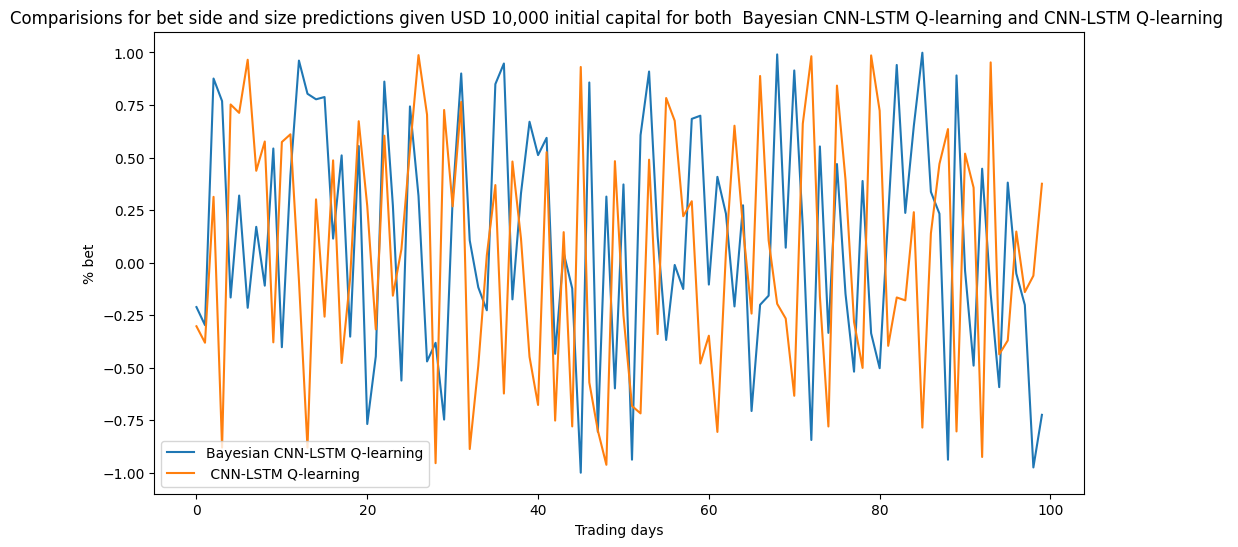

In [266]:
plt.figure(figsize=(12, 6))
plt.plot(actions_live, label='Bayesian CNN-LSTM Q-learning')
plt.plot(actions_live_cnn_lstm, label=' CNN-LSTM Q-learning')
plt.xlabel('Trading days')
plt.ylabel('% bet')
plt.title(
    'Comparisions for bet side and size predictions given USD 10,000 initial capital for both  Bayesian CNN-LSTM Q-learning and CNN-LSTM Q-learning '
         )
plt.legend()
plt.show()

In [267]:
cum_reward_cnn_lstm=evaluate_actions(
    actions=actions_live_cnn_lstm,
    market_returns=y_live,
    num_trades=10
)

In [268]:
data_live_4['Capital_cnn_lstm']=cum_reward_cnn_lstm[4]

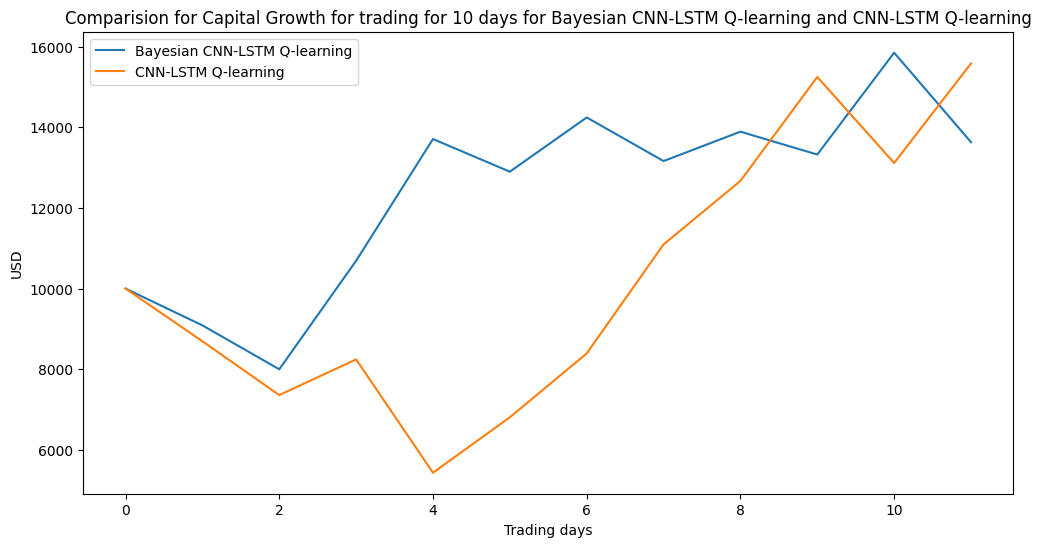

In [269]:

plt.figure(figsize=(12, 6))
plt.plot(data_live_4['Capital'], label='Bayesian CNN-LSTM Q-learning')
plt.plot(
    data_live_4['Capital_cnn_lstm'],
    label='CNN-LSTM Q-learning'
)
plt.xlabel('Trading days')
plt.ylabel('USD')
plt.title(
    'Comparision for Capital Growth for trading for 10 days for Bayesian CNN-LSTM Q-learning and CNN-LSTM Q-learning'
)
plt.legend()
plt.show()

**Profit comparisions**

In [270]:
# Bayesian CNN-LSTM Q-learning
print(
    f"Total profit = {cum_reward[0]}",
    f"%-profit = {cum_reward[1]}",
    f"Total trades = {cum_reward[2]}"
    )

Total profit = 4100.65129072707 %-profit = 41.0065129072707 Total trades = 10


In [271]:
# CNN-LSTM Q-learning
print(
    f"Total profit = {cum_reward_cnn_lstm[0]}",
    f"%-profit = {cum_reward_cnn_lstm[1]}",
    f"Total trades = {cum_reward_cnn_lstm[2]}"
    )

Total profit = 6169.304903650239 %-profit = 61.69304903650239 Total trades = 10


**General sgents performance based on the number of trades**

In [272]:
num_trades_profits_cnn_lstm=[]
num_trades_percentage_profits_cnn_lstm=[]
num_trades_cum_reward_cnn_lstm=[]
for i in range(1,101):
    cum_reward_=evaluate_actions(
        actions=actions_live_cnn_lstm,
        market_returns=y_live,
        num_trades=i
    )
    num_trades_profits_cnn_lstm.append(cum_reward_[0])
    num_trades_percentage_profits_cnn_lstm.append(cum_reward_[1])
    #Get the cummulative capital on the last trading day
    num_trades_cum_reward_cnn_lstm.append(cum_reward_[4][-1])

In [273]:
trade_databay_cnn_lstm={
    "profit_cnn_lstm":num_trades_profits_cnn_lstm,
    "percentage_profit_cnn_lstm":num_trades_percentage_profits_cnn_lstm,
    "capital_cnn_lstm":num_trades_cum_reward_cnn_lstm
}
data_live_5['profit_cnn_lstm']=num_trades_profits_cnn_lstm
data_live_5['percentage_profit_cnn_lstm']=num_trades_percentage_profits_cnn_lstm
data_live_5['capital_cnn_lstm']=num_trades_cum_reward_cnn_lstm

**Statistical Summaries of the trade**

In [274]:
data_live_5.describe()

,profit,percentage_profit,capital,profit_cnn_lstm,percentage_profit_cnn_lstm,capital_cnn_lstm,profit_bay_cnn,percentage_profit_bay_cnn,capital_bay_cnn
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,48667.380755,486.673808,48741.286118,4597.352553,45.973526,11207.960032,3512.239236,35.122392,10818.180620
std,22806.859535,228.068595,17488.590802,4371.249350,43.712494,5096.115758,2938.303385,29.383034,3624.674066
min,-1954.138739,-19.541387,7997.720271,-4409.414467,-44.094145,5431.670748,-1272.913302,-12.729133,6315.130436
25%,30497.879862,304.978799,37347.147885,2245.490590,22.454906,7538.698475,1188.114378,11.881144,7220.711064
50%,59533.747939,595.337479,55364.160782,3253.270459,32.532705,8202.446402,2264.668805,22.646688,10570.013809
75%,66163.825686,661.638257,58871.838426,5963.971613,59.639716,14670.491519,5818.024649,58.180246,13677.834608
max,86931.182176,869.311822,90367.524775,21950.973871,219.509739,29552.931223,11330.556982,113.305570,20731.833541


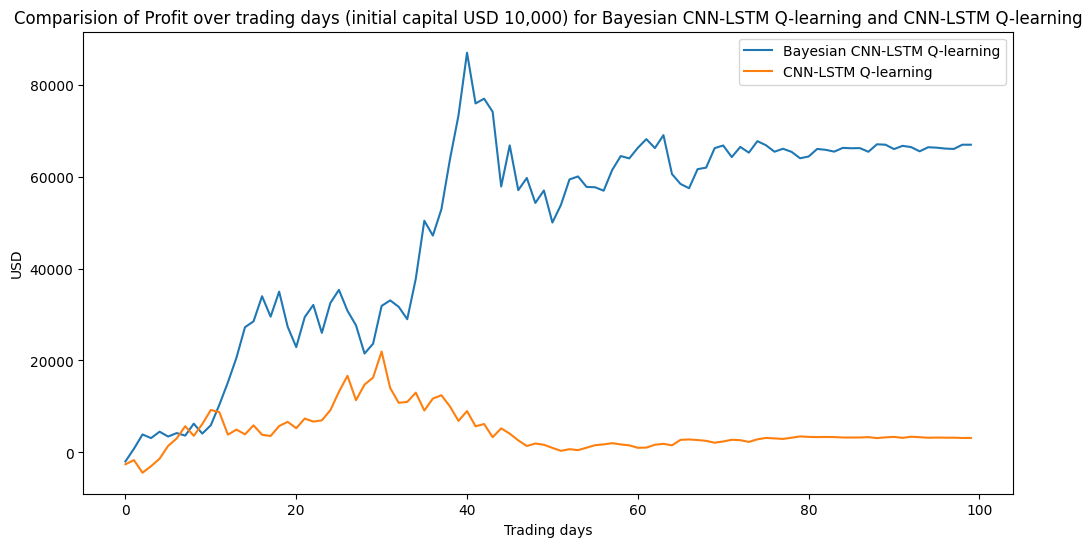

In [275]:

plt.figure(figsize=(12, 6))
plt.plot(data_live_5['profit'], label="Bayesian CNN-LSTM Q-learning")
plt.plot(data_live_5['profit_cnn_lstm'], label="CNN-LSTM Q-learning")
plt.xlabel('Trading days')
plt.ylabel('USD')
plt.title(
    'Comparision of Profit over trading days (initial capital USD 10,000) for Bayesian CNN-LSTM Q-learning and CNN-LSTM Q-learning'
 )
plt.legend()
plt.show()

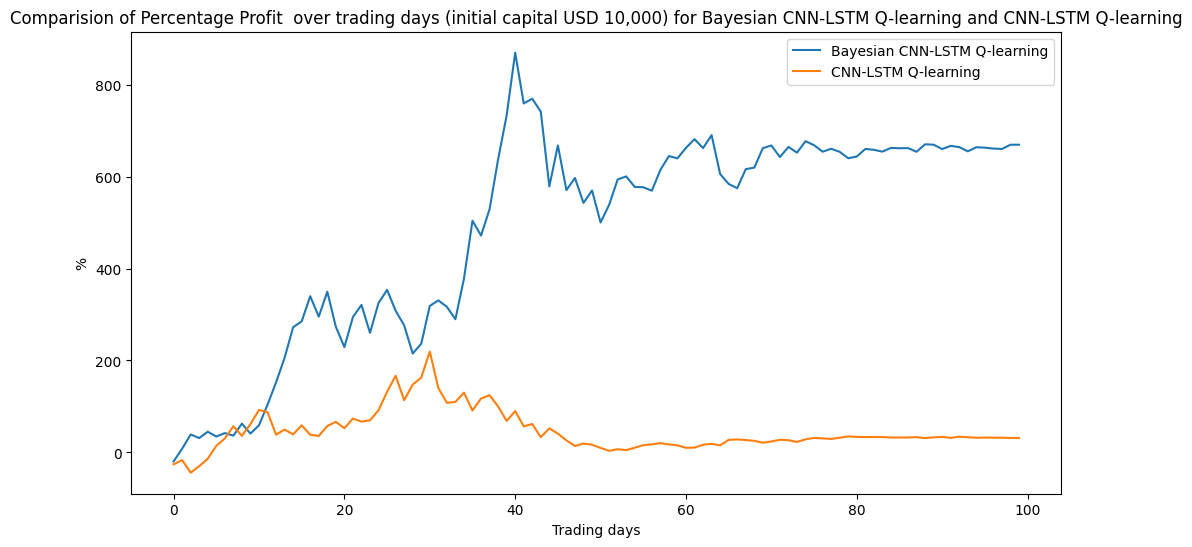

In [276]:
plt.figure(figsize=(12, 6))
plt.plot(
    data_live_5['percentage_profit'],
    label="Bayesian CNN-LSTM Q-learning"
)
plt.plot(
    data_live_5['percentage_profit_cnn_lstm'],
    label="CNN-LSTM Q-learning"
)
plt.xlabel('Trading days')
plt.ylabel('%')
plt.title(
    'Comparision of Percentage Profit  over trading days (initial capital USD 10,000) for Bayesian CNN-LSTM Q-learning and CNN-LSTM Q-learning'
    )
plt.legend()
plt.show()

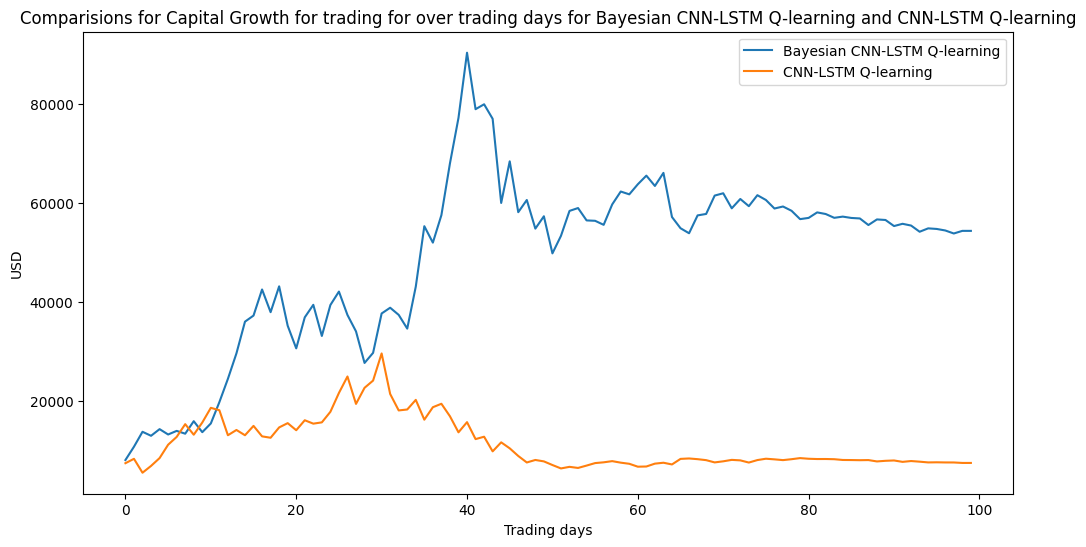

In [277]:
plt.figure(figsize=(12, 6))
plt.plot(
    data_live_5['capital'],
    label='Bayesian CNN-LSTM Q-learning'
)
plt.plot(
    data_live_5['capital_cnn_lstm'],
    label='CNN-LSTM Q-learning'
)
plt.xlabel('Trading days')
plt.ylabel('USD')
plt.title(
    'Comparisions for Capital Growth for trading for over trading days for Bayesian CNN-LSTM Q-learning and CNN-LSTM Q-learning'
)
plt.legend()
plt.show()

# **7. Marketing Timing using Bayesian CNN Q-learning**

Now let's build  a bayesian CNN deep Q-learning. The idea is to test how the q-learning agent will perform if the primary model is not a hybrid of CNN and LSTM, but still have the uncertainty of it's predictions estimated and fed to the agent.

In [157]:
# For creating model and training
model_bay_cnn = Sequential()

# Creating the Neural Network model here...
# CNN layers
model_bay_cnn.add(
    TimeDistributed(
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 1,100, 1)
              )
    )
)
model_bay_cnn.add(
    TimeDistributed(
        Dropout(0.25)
    )
)
model_bay_cnn.add(
    TimeDistributed(
        MaxPooling1D(2)
    )
)
model_bay_cnn.add(
    TimeDistributed(
        Conv1D(128, kernel_size=3, activation='relu')
    )
)
model_bay_cnn.add(
    TimeDistributed(
        MaxPooling1D(2)
    )
)
model_bay_cnn.add(
    TimeDistributed(
        Conv1D(64, kernel_size=3, activation='relu')
    )
)

model_bay_cnn.add(TimeDistributed(MaxPooling1D(2)))
model_bay_cnn.add(TimeDistributed(Flatten()))
#Final layers
model_bay_cnn.add(Dense(1, activation='linear'))
model_bay_cnn.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

**Enable dropout during inference**


In [158]:
def enable_dropout_bay_cnn(model_bay_cnn):
    for layer in model_bay_cnn.layers:
        if isinstance(layer, (Dropout, TimeDistributed)):
            layer.training = True

**Train the Bayesian CNN model**

In [159]:
# # Train the model

history_bay_cnn = model_bay_cnn.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
    verbose=0
)


In [152]:
X_test.shape

(634, 1, 100, 1)

**Make multiple predictions**

In [165]:
num_predictions_bay_cnn = 100
predictions_bay_cnn = []

for _ in range(num_predictions_bay_cnn):
    enable_dropout_bay_cnn(model_bay_cnn)
    pred = model_bay_cnn.predict(X_test,verbose=0)  # x_test is your test data
    # print(pred.shape)
    # print("predicted")
    predictions_bay_cnn.append(pred)

predictions_bay_cnn = np.array(predictions_bay_cnn)


**Aggregate the predictions**

In [166]:
mean_prediction_bay_cnn = np.mean(predictions_bay_cnn, axis=0)
uncertainty_bay_cnn = np.var(predictions_bay_cnn, axis=0)


In [167]:
uncertainty_bay_cnn.shape

(634, 1, 1)

In [168]:
# Reshape the uncertainty
uncertainty_bay_cnn=np.reshape(uncertainty_bay_cnn,[uncertainty_bay_cnn.shape[0],1])

In [169]:
uncertainty_bay_cnn.shape

(634, 1)

In [170]:
# From the trained Bayesian CNN-LSTM
num_predictions = 100
predictions = []

for _ in range(num_predictions):
    enable_dropout(loaded_bay_cnn_lstm_model)
    pred = loaded_bay_cnn_lstm_model.predict(X_test,verbose=0)  # x_test is your test data
    # print(pred.shape)
    # break
    predictions.append(pred)

predictions = np.array(predictions)
mean_prediction = np.mean(predictions, axis=0)
uncertainty = np.var(predictions, axis=0)


In [171]:
uncertainty.shape

(634, 1)

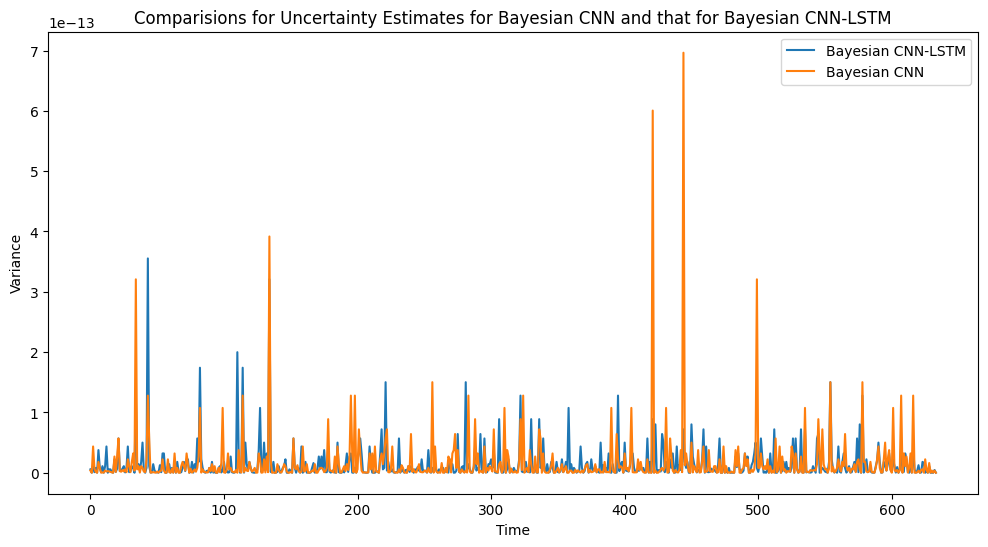

In [172]:
# uncertainty
plt.figure(figsize=(12, 6))
plt.plot(uncertainty, label='Bayesian CNN-LSTM')
plt.plot(uncertainty_bay_cnn, label='Bayesian CNN')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title('Comparisions for Uncertainty Estimates for Bayesian CNN and that for Bayesian CNN-LSTM')
plt.legend()
plt.show()

**Save Bayesian CNN model**

In [173]:
# Save the model architecture as JSON
model_bay_cnn_json = model_bay_cnn.to_json()
with open("model_architecture_bay_cnn.json", "w") as json_file:
    json_file.write(model_bay_cnn_json)

# Save the model weights
model_bay_cnn.save_weights("trained_weights_bay_cnn.h5")

# Optionally, saving the entire model (including architecture and weights) in a single .h5 file
model_bay_cnn.save("complete_bayesian_cnn.h5")


In [174]:
# # Evaluate the model on the validation and test sets
val_loss_bay_cnn = model_bay_cnn.evaluate(X_val, y_val)
test_loss_bay_cnn = model_bay_cnn.evaluate(X_test, y_test)
print("Validation loss:", val_loss_bay_cnn)
print("Test loss:", test_loss_bay_cnn)

# Make predictions
y_pred_bay_cnn = model_bay_cnn.predict(X_test)

20/20 [==============================] - 0s 10ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0504
Validation loss: [0.004533048719167709, 0.004533048719167709, 0.051954858005046844]
Test loss: [0.004349007271230221, 0.004349007271230221, 0.05035331845283508]
20/20 [==============================] - 0s 14ms/step


In [180]:
y_pred_bay_cnn.shape

(634, 1, 1)

In [186]:
y_pred_bay_cnn=np.reshape(y_pred_bay_cnn,[y_pred_bay_cnn.shape[0],1])

In [187]:
data2["pred_bayesian_cnn"]=y_pred_bay_cnn

In [188]:
data2

,pred,real,pred_bayesian_cnn
0,0.078436,[[0.07325274729238496]],0.069120
1,0.004642,[[0.03842559461456542]],0.000967
2,0.132274,[[0.16137264609921742]],0.144411
3,0.096807,[[0.09615067199751381]],0.084266
4,0.087289,[[0.09673097399040065]],0.072801
...,...,...,...
629,0.010501,[[-0.06192146481929599]],-0.004028
630,0.075490,[[0.14251778602580817]],0.069729
631,0.031253,[[0.05668098780701301]],0.008192
632,0.075320,[[0.07631655504664701]],0.072920


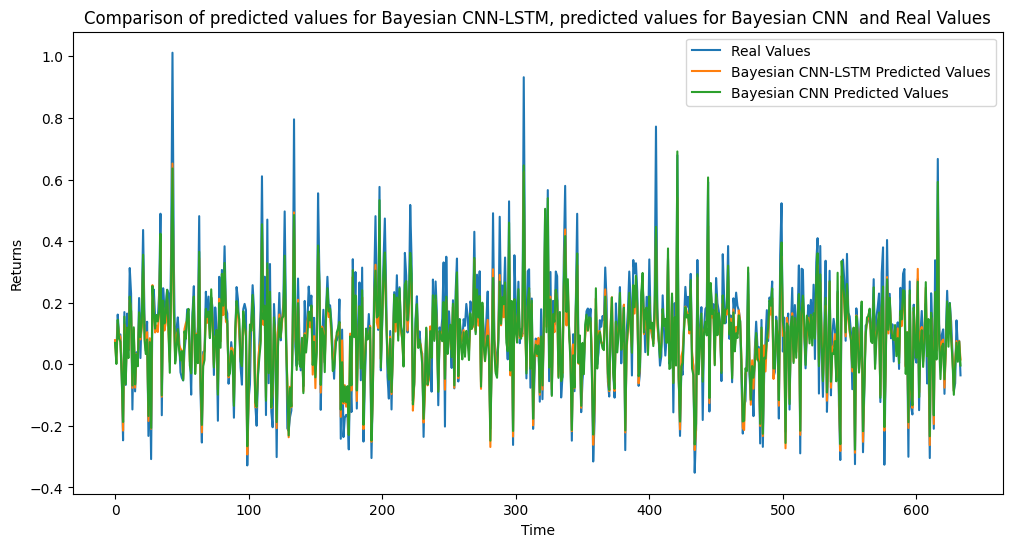

In [191]:


plt.figure(figsize=(12, 6))
plt.plot(data2['real'], label='Real Values')
plt.plot(data2['pred'], label='Bayesian CNN-LSTM Predicted Values')
plt.plot(data2['pred_bayesian_cnn'], label='Bayesian CNN Predicted Values')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title('Comparison of predicted values for Bayesian CNN-LSTM, predicted values for Bayesian CNN  and Real Values')
plt.legend()
plt.show()

**Market timing with the Bayesian CNN Q-learning agent**

In [192]:
# Function to get states from your Bayesian CNN model and incorporate uncertainty
def get_states_bay_cnn():
    # create an extended state that incorporated uncertainty estimation
    # and the predictions
    # We limit the state size to 100*2
    # This is necessary to maintain consistency
    extended_state = np.concatenate((y_pred_bay_cnn[:100,:], uncertainty_bay_cnn[:100,:]), axis=1)
    return extended_state

In [193]:


# The DQN agent
class DQNAgentBayesianCNN:
    def __init__(self, state_size, action_size,uncertainty_penalty):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=200)  # Experience replay buffer
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration-exploitation trade-off
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.uncertainty_penalty=uncertainty_penalty
        self.model = self._build_model()

    def _huber_loss(self,y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond  = keras_b.abs(error) <= clip_delta

        squared_loss = 0.5 * keras_b.square(error)
        quadratic_loss = (
                    0.5 * keras_b.square(clip_delta) +
                    clip_delta * (keras_b.abs(error) - clip_delta)
                )

        return keras_b.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        model = Sequential()
        model.add(Flatten(input_shape=(state_size, 2)))  # Flatten layer to reshape input
        model.add(Dense(24, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(
            loss=self._huber_loss, 
            optimizer=Adam(learning_rate=self.learning_rate)
        )
        # model = Sequential()
        # model.add(Dense(24, activation='relu'))
        # model.add(Dense(24, activation='relu'))
        # model.add(Dense(self.action_size, activation='linear'))
        # model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        # print(state.shape)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state,current_holding=0):
        if np.random.rand() <= self.epsilon:
            # Randomly select action from the action space: short, do nothing, long
            return np.random.uniform(-1, 1)
        else:
            # Use the Q-network to select action based on state
            return np.argmax(self.model.predict(state,verbose=0)[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            # print(next_state.shape)
            if not done:
                # print(self.model.predict(next_state))
                target = reward + self.gamma * np.amax(self.model.predict(next_state,verbose=0)[0])
            # print(state.shape)
            target_f = self.model.predict(state,verbose=0)
            # print(action)
            target_f[0][0] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# The Market environment
class MarketEnvironmentBayesianCNN:
    def __init__(self,agent, max_episode_length=100, min_available_capital=10, max_trades=None, profit_target=None, stop_loss=-5000):
        self.state_size = state_size  # The actual size of your state
        self.action_size = 1  # Example: Buy, Sell, Hold
        self.initial_capital = 10000  # Initial available capital
        self.transaction_cost = 0.01  # Transaction charge (1%)
        self.current_capital = self.initial_capital
        self.max_episode_length = max_episode_length
        self.min_available_capital = min_available_capital
        self.max_trades = max_trades
        self.profit_target = profit_target
        self.stop_loss = stop_loss
        self.num_trades = 0
        self.total_reward = 0
        self.uncertainty_penalty=agent.uncertainty_penalty

    def reset(self):
        # Reset logic
        self.current_capital = self.initial_capital
        self.num_trades = 0
        self.total_reward = 0
        # print(self.state_size)
        return np.random.rand(self.state_size)

    def step(self, action,time_state):
        # Extract market returns and uncertainty from the state
        market_returns = time_state[0]  # First column contains predicted market returns
        uncertainty = time_state[1]     # Second column contains uncertainty estimations
        # Simulated step function, returns next_state, reward, done
        next_state = np.random.rand(self.state_size,2)

        # Calculate bet size based on the selected action
        bet_size = abs(action) * self.current_capital

        # Calculate transaction cost based on the bet size
        total_transaction_cost=self.transaction_cost * bet_size
        # Subtract the transaction cost
        self.current_capital -= total_transaction_cost
        # Calculate the return based on the market return and the direction of the trade
        # For a long position, return is market return * bet size
        # For not taking any position, return is 0
        if action > 0:
            return_direction = 1
        elif action<0:
            return_direction = -1
        else:
            return_direction = 0
        return_amount = return_direction * market_returns * bet_size
        yield_size=return_amount+bet_size
        if action > 0:
            # Adjust available capital based on bet size
            self.current_capital += return_amount
    
        # If action == 0, it means the agent wants to close the position
        elif action == 0:
            # Adjust available capital based on the current holding
            self.current_capital += return_amount
        # Calculate reward based on market return, transaction charges, and uncertainty
        reward = return_amount
        #Since the uncertainty is calculated from return predictions, 
        # The corresponding estimates take lower scales .i.e 1e-13
        # We have to scale this so that it can have effect on the reward
        # We scale by multiplying the uncertainty by 1e-11
        reward -= self.uncertainty_penalty * uncertainty*return_amount*1e-11 
        # Increment total reward
        self.total_reward += reward

        # Increment number of trades
        self.num_trades += 1
         # Check termination conditions
        done = False
        if self.num_trades >= self.max_episode_length:
            done = True
        elif self.current_capital <= self.min_available_capital:
            done = True
        elif self.max_trades is not None and self.num_trades >= self.max_trades:
            done = True
        elif self.profit_target is not None and self.total_reward >= self.profit_target:
            done = True
        elif self.stop_loss is not None and self.total_reward <= self.stop_loss:
            done = True
        return next_state, reward, done


In [194]:
# Hyperparameters
states=get_states_bay_cnn()
state_size = states.size # The actual size of your state
print(state_size)
state_size=int(state_size/2) #The halfed state size for the input size
print(state_size)
action_size = 1  # Percentage defined as a ratio
batch_size = 32
# # market return

# Create the environment and agent
agent_bayesian_cnn = DQNAgentBayesianCNN(state_size, action_size, UNCERTAINTY_PENALTY)
env_bayesian_cnn = MarketEnvironmentBayesianCNN(agent_bayesian_cnn)



# Training the DQN agent
for episode in range(EPISODES):  # Replace with the desired number of episodes
    state = env_bayesian_cnn.reset()
    state_from_cnn = get_states_bay_cnn()
    # state=state_from_lstm
    state = np.reshape(state_from_cnn, [1, state_size, 2])
    # print(state)
    total_episode_reward = 0  # Initialize total reward for the episode

    for time in range(EPISODE_LENGTH):  # Replace with the desired episode length
        action = agent_bayesian_cnn.act(state)
        # print(market_returns_array[time])
        # Get this time state for reward calculation
        # print(state.shape)
        time_state=state[0][time]
        # print(time_state,time,episode)
        next_state, reward, done = env_bayesian_cnn.step(action,time_state)
        next_state = np.reshape(next_state, [1, state_size, 2])
        # print(state.shape)
        agent_bayesian_cnn.remember(state, action, reward, next_state, done)
        state = next_state
        total_episode_reward += reward  # Accumulate the reward obtained at each time step
        if done:
            print("Episode: {}/{}, Reward score: {}".format(episode+1, EPISODES, total_episode_reward))
            break
        # print(batch_size)
        if len(agent_bayesian_cnn.memory) > batch_size:
            agent_bayesian_cnn.replay(batch_size)

200
100
Episode: 1/40, Reward score: -7359.454289713845
Episode: 2/40, Reward score: -8252.83543120435
Episode: 3/40, Reward score: -25626.54677981978
Episode: 4/40, Reward score: -6745.918327585032
Episode: 5/40, Reward score: -6095.851209570532
Episode: 6/40, Reward score: -5504.140028830071
Episode: 7/40, Reward score: -9180.137751835859
Episode: 8/40, Reward score: -7627.4425355045305
Episode: 9/40, Reward score: -10035.047181861448
Episode: 10/40, Reward score: -22503.23998500572
Episode: 11/40, Reward score: -6171.367248093127
Episode: 13/40, Reward score: -21166.49567092733
Episode: 15/40, Reward score: -21718.03604126786
Episode: 16/40, Reward score: -7611.338167994795
Episode: 17/40, Reward score: -5634.821426713582
Episode: 18/40, Reward score: -17909.18260294973
Episode: 21/40, Reward score: -6808.155419559274
Episode: 22/40, Reward score: -6814.848477951175
Episode: 26/40, Reward score: -21400.538856795818
Episode: 29/40, Reward score: -6062.483594196465
Episode: 30/40, Rew

**Save the bayesian CNN Q-learning agent model**

In [195]:
# Save DQNAgent object weights
agent_bayesian_cnn.model.save_weights('trained_qql_weights_bayesian_cnn.h5')
# Assuming your agent is called 'agent'


# Save the agent's configurations using pickle
agent_config_bayesian_cnn = {
    'state_size': agent_bayesian_cnn.state_size,
    'action_size': agent_bayesian_cnn.action_size,
    # Add any other relevant configurations of your agent here
}
print(agent_config_bayesian_cnn)
with open("trained_qql_agent_config_bayesian_cnn.pkl", "wb") as config_file:
    pickle.dump(agent_config_bayesian_cnn, config_file)

{'state_size': 100, 'action_size': 1}


**Backtest Bayesian CNN Q-learning**

In [196]:
# Load the saved model
loaded_model_bay_cnn = load_model('complete_bayesian_cnn.h5')

6/6 [==============================] - 1s 17ms/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0451
Prediction loss: [0.003055047243833542, 0.003055047243833542, 0.04513537138700485]


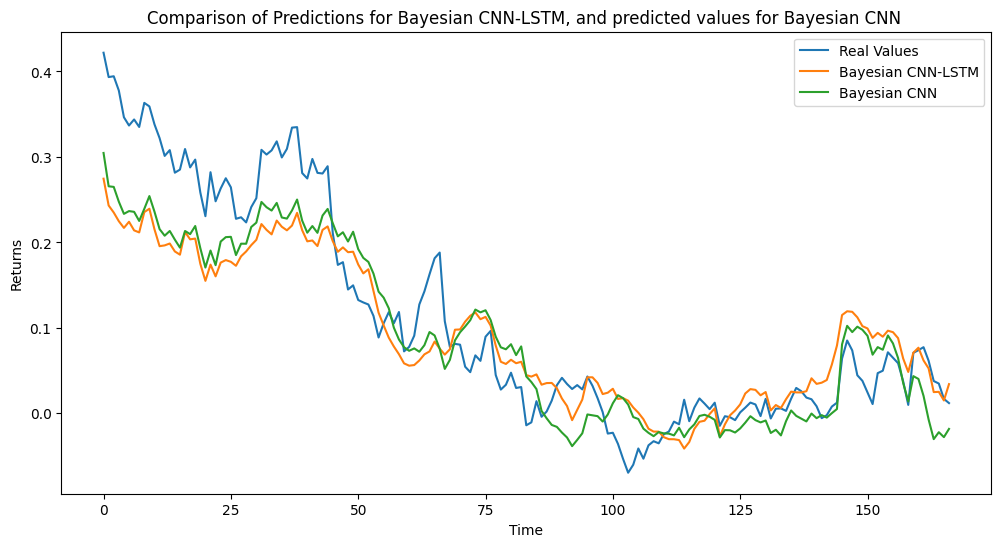

In [197]:
# Plot the graph comparing predicted values and real values
y_pred_live_bay_cnn = loaded_model_bay_cnn.predict(X_live)
pred_loss_bay_cnn = loaded_model_bay_cnn.evaluate(X_live, y_live)
# reshape to fit the model
y_pred_live_bay_cnn=np.reshape(y_pred_live_bay_cnn,[y_pred_live_bay_cnn.shape[0],1])
print("Prediction loss:", pred_loss_bay_cnn)
data_live_2["pred_bay_cnn"]=y_pred_live_bay_cnn  
plt.figure(figsize=(12, 6))
plt.plot(data_live_2['real'], label='Real Values')
plt.plot(data_live_2['pred'], label='Bayesian CNN-LSTM')
plt.plot(data_live_2['pred_bay_cnn'], label='Bayesian CNN')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.title(
    'Comparison of Predictions for Bayesian CNN-LSTM, and predicted values for Bayesian CNN '
)
plt.legend()
plt.show()

**Estimate the uncertainty of the predictions**

In [198]:
num_predictions_live_bay_cnn = 100
predictions_live_bay_cnn = []

for _ in range(num_predictions_live_bay_cnn):
    enable_dropout_bay_cnn(loaded_model_bay_cnn)
    pred = loaded_model_bay_cnn.predict(X_live,verbose=0) 
    predictions_live_bay_cnn.append(pred)

predictions_live_bay_cnn = np.array(predictions_live_bay_cnn)


In [199]:
mean_prediction_live_bay_cnn = np.mean(predictions_live_bay_cnn, axis=0)
uncertainty_live_bay_cnn = np.var(predictions_live_bay_cnn, axis=0)

In [200]:
# Reshape the uncertainty
uncertainty_live_bay_cnn=np.reshape(
    uncertainty_live_bay_cnn,
    [uncertainty_live_bay_cnn.shape[0],1]
)

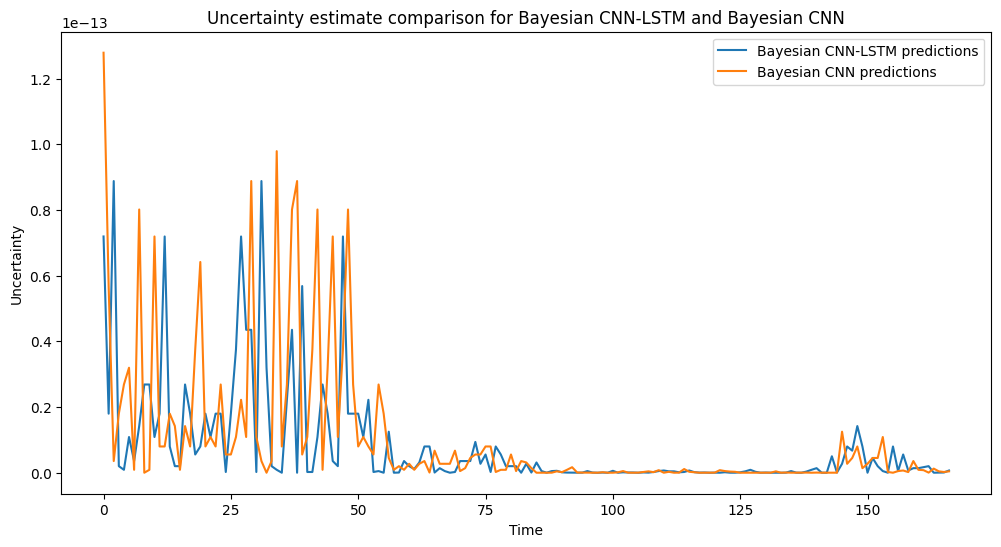

In [201]:
# uncertainty

plt.figure(figsize=(12, 6))
plt.plot(uncertainty_live, label='Bayesian CNN-LSTM predictions')
plt.plot(uncertainty_live_bay_cnn, label='Bayesian CNN predictions')
plt.xlabel('Time')
plt.ylabel('Uncertainty')
plt.title('Uncertainty estimate comparison for Bayesian CNN-LSTM and Bayesian CNN')
plt.legend()
plt.show()

**Loading Bayesian CNN Q-learning agent**

In [202]:
# Function to get states from your Bayesian CNN-LSTM model and incorporate uncertainty
def get_states_live_bay_cnn():
    # create an extended state that incorporated uncertainty estimation
    # and the predictionsd
    extended_state = np.concatenate(
        (y_pred_live_bay_cnn[:100,:], 
         uncertainty_live_bay_cnn[:100,:]),
        axis=1
    )
    return extended_state


# # Hyperparameters
states=get_states_live_bay_cnn()
state_size = states.size # The actual size of your state
state_size=int(state_size/2) #The halfed state size for the input size
print(state_size)
action_size = 1  # Percentage defined as a ratio
batch_size = 32
# market return
# Load trained model weights
loaded_dqq_agent_bay_cnn = DQNAgentBayesianCNN(
    state_size, action_size,UNCERTAINTY_PENALTY
)
loaded_dqq_agent_bay_cnn.model.load_weights('trained_qql_weights_bayesian_cnn.h5')

100


**Make Betsize predictions**

In [278]:

# Predict actions (sizes of bets)
actions_live_bay_cnn = []
for state in states:
    action = loaded_dqq_agent_bay_cnn.act(state)
    actions_live_bay_cnn.append(action)

# print("Predicted actions:", actions_live)

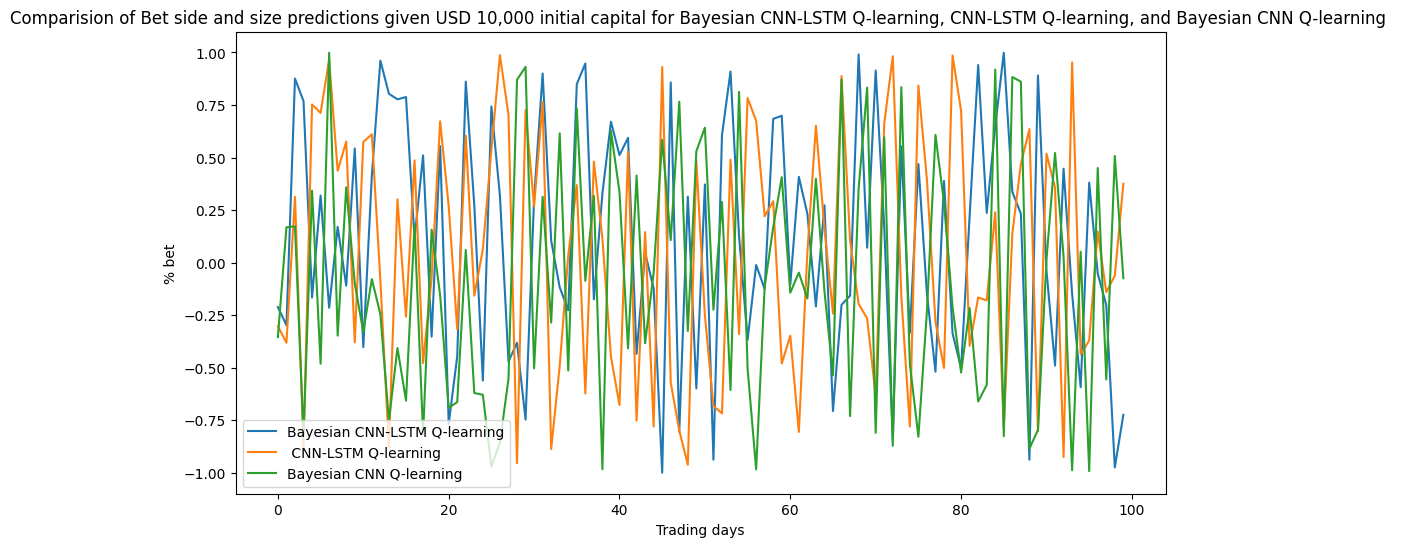

In [279]:
plt.figure(figsize=(12, 6))
plt.plot(actions_live, label='Bayesian CNN-LSTM Q-learning')
plt.plot(actions_live_cnn_lstm, label=' CNN-LSTM Q-learning')
plt.plot(actions_live_bay_cnn, label='Bayesian CNN Q-learning')
plt.xlabel('Trading days')
plt.ylabel('% bet')
plt.title(
    'Comparision of Bet side and size predictions given USD 10,000 initial capital for Bayesian CNN-LSTM Q-learning, CNN-LSTM Q-learning, and Bayesian CNN Q-learning '
         )
plt.legend()
plt.show()

In [280]:
cum_reward_bay_cnn=evaluate_actions(
    actions=actions_live_bay_cnn,
    market_returns=y_live,
    num_trades=10
)

In [281]:
data_live_4['Capital_bayesian_cnn']=cum_reward_bay_cnn[4]

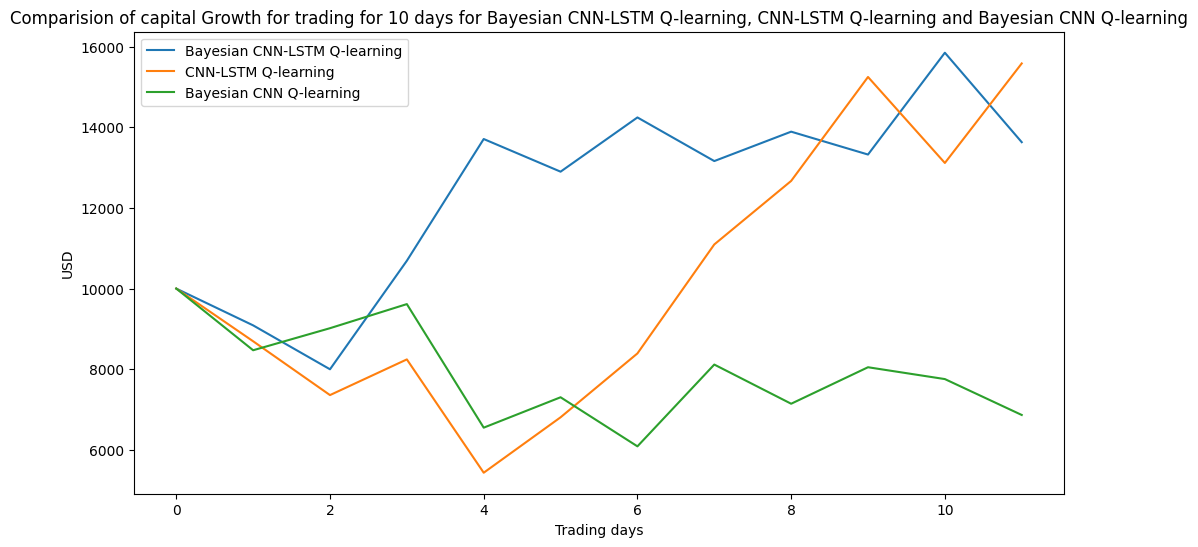

In [282]:

plt.figure(figsize=(12, 6))
plt.plot(data_live_4['Capital'], label='Bayesian CNN-LSTM Q-learning')
plt.plot(
    data_live_4['Capital_cnn_lstm'],
    label='CNN-LSTM Q-learning'
)
plt.plot(
    data_live_4['Capital_bayesian_cnn'],
    label='Bayesian CNN Q-learning'
)
plt.xlabel('Trading days')
plt.ylabel('USD')
plt.title(
    'Comparision of capital Growth for trading for 10 days for Bayesian CNN-LSTM Q-learning, CNN-LSTM Q-learning and Bayesian CNN Q-learning'
)
plt.legend()
plt.show()

**Profit comparisions**

In [283]:
# Bayesian CNN-LSTM Q-learning
print(
    f"Total profit = {cum_reward[0]}",
    f"%-profit = {cum_reward[1]}",
    f"Total trades = {cum_reward[2]}"
    )

Total profit = 4100.65129072707 %-profit = 41.0065129072707 Total trades = 10


In [284]:
# CNN-LSTM Q-learning
print(
    f"Total profit = {cum_reward_cnn_lstm[0]}",
    f"%-profit = {cum_reward_cnn_lstm[1]}",
    f"Total trades = {cum_reward_cnn_lstm[2]}"
    )

Total profit = 6169.304903650239 %-profit = 61.69304903650239 Total trades = 10


In [285]:
# Bayesian CNN Q-learning
print(
    f"Total profit = {cum_reward_bay_cnn[0]}",
    f"%-profit = {cum_reward_bay_cnn[1]}",
    f"Total trades = {cum_reward_bay_cnn[2]}"
    )

Total profit = -2785.707138620319 %-profit = -27.857071386203184 Total trades = 10


**Agents performance based on the number of trades**

In [286]:
num_trades_profits_bay_cnn=[]
num_trades_percentage_profits_bay_cnn=[]
num_trades_cum_reward_bay_cnn=[]
for i in range(1,101):
    cum_reward_=evaluate_actions(
        actions=actions_live_bay_cnn,
        market_returns=y_live,
        num_trades=i
    )
    num_trades_profits_bay_cnn.append(cum_reward_[0])
    num_trades_percentage_profits_bay_cnn.append(cum_reward_[1])
    #Get the cummulative capital on the last trading day
    num_trades_cum_reward_bay_cnn.append(cum_reward_[4][-1])

In [287]:
trade_databay_cnn={
    "profit_bay_cnn":num_trades_profits_bay_cnn,
    "percentage_profit_bay_cnn":num_trades_percentage_profits_bay_cnn,
    "capital_bay_cnn":num_trades_cum_reward_bay_cnn
}
data_live_5['profit_bay_cnn']=num_trades_profits_bay_cnn
data_live_5['percentage_profit_bay_cnn']=num_trades_percentage_profits_bay_cnn
data_live_5['capital_bay_cnn']=num_trades_cum_reward_bay_cnn

**Statistical summaries of the trade**

In [288]:
data_live_5.describe()

,profit,percentage_profit,capital,profit_cnn_lstm,percentage_profit_cnn_lstm,capital_cnn_lstm,profit_bay_cnn,percentage_profit_bay_cnn,capital_bay_cnn
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,48667.380755,486.673808,48741.286118,4597.352553,45.973526,11207.960032,-7552.493166,-75.524932,1803.023453
std,22806.859535,228.068595,17488.590802,4371.249350,43.712494,5096.115758,2080.994995,20.809950,2247.775487
min,-1954.138739,-19.541387,7997.720271,-4409.414467,-44.094145,5431.670748,-8783.417207,-87.834172,546.401331
25%,30497.879862,304.978799,37347.147885,2245.490590,22.454906,7538.698475,-8532.679500,-85.326795,719.887706
50%,59533.747939,595.337479,55364.160782,3253.270459,32.532705,8202.446402,-8459.567501,-84.595675,824.281048
75%,66163.825686,661.638257,58871.838426,5963.971613,59.639716,14670.491519,-8298.073313,-82.980733,1018.129825
max,86931.182176,869.311822,90367.524775,21950.973871,219.509739,29552.931223,-319.813699,-3.198137,9614.943956


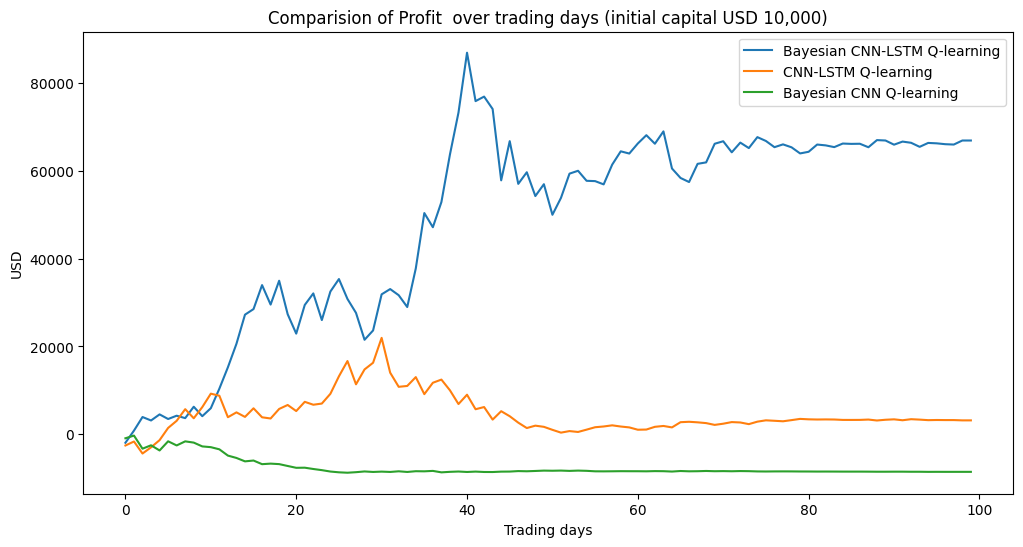

In [289]:

plt.figure(figsize=(12, 6))
plt.plot(data_live_5['profit'], label="Bayesian CNN-LSTM Q-learning")
plt.plot(data_live_5['profit_cnn_lstm'], label="CNN-LSTM Q-learning")
plt.plot(data_live_5['profit_bay_cnn'], label="Bayesian CNN Q-learning")
plt.xlabel('Trading days')
plt.ylabel('USD')
plt.title('Comparision of Profit  over trading days (initial capital USD 10,000)')
plt.legend()
plt.show()

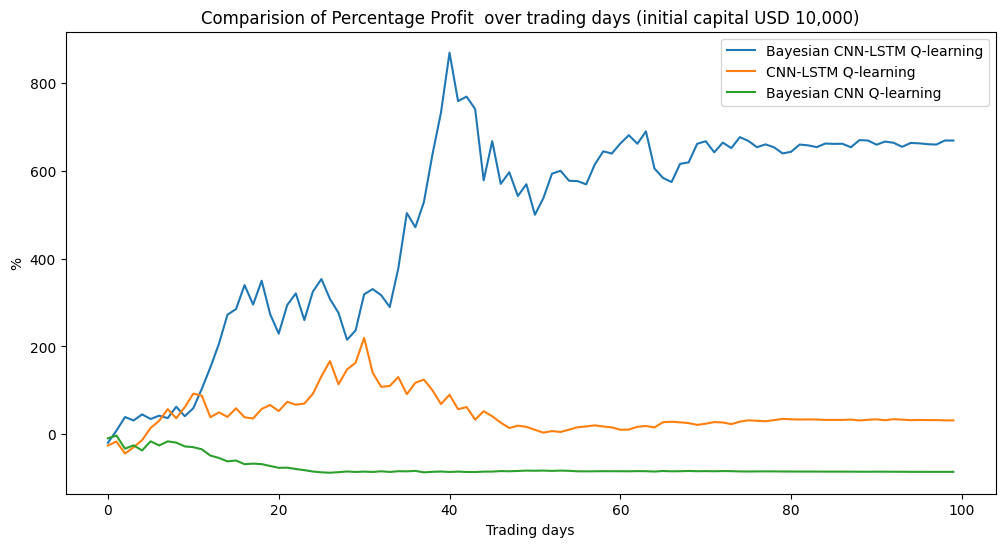

In [290]:
plt.figure(figsize=(12, 6))
plt.plot(
    data_live_5['percentage_profit'],
    label="Bayesian CNN-LSTM Q-learning"
)
plt.plot(
    data_live_5['percentage_profit_cnn_lstm'],
    label="CNN-LSTM Q-learning"
)
plt.plot(
    data_live_5['percentage_profit_bay_cnn'],
    label="Bayesian CNN Q-learning"
)
plt.xlabel('Trading days')
plt.ylabel('%')
plt.title('Comparision of Percentage Profit  over trading days (initial capital USD 10,000)')
plt.legend()
plt.show()

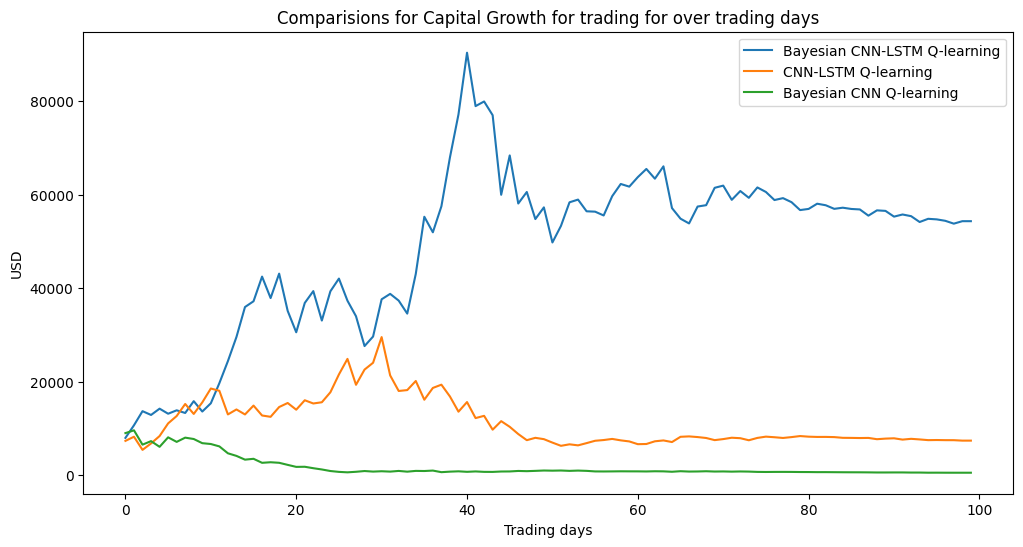

In [291]:
plt.figure(figsize=(12, 6))
plt.plot(
    data_live_5['capital'],
    label='Bayesian CNN-LSTM Q-learning'
)
plt.plot(
    data_live_5['capital_cnn_lstm'],
    label='CNN-LSTM Q-learning'
)
plt.plot(
    data_live_5['capital_bay_cnn'],
    label='Bayesian CNN Q-learning'
)
plt.xlabel('Trading days')
plt.ylabel('USD')
plt.title('Comparisions for Capital Growth for trading for over trading days')
plt.legend()
plt.show()